![qqq](../resources/header.jpg)

**Машинное обучение**
***

О сайте **VGChartz.com**:

"Компания **VGChartz (Video Game Charts)**, основанная в 2005 году Бреттом Уолтоном, является фирмой по бизнес-аналитике и исследованиям, а также издателем веб-сайтов **VGChartz.com**. Как отраслевая исследовательская фирма, VGChartz каждую неделю публикует оценки оборудования для видеоигр и размещает постоянно расширяющуюся базу данных игр, в которой содержится более 55 000 наименований, содержащая актуальную информацию о поставках и устаревшие данные о продажах. Веб-сайт VGChartz.com предоставляет потребителям разнообразный контент: от новостей и продаж до обзоров и статей, социальных сетей и форумов сообщества". - с сайта **[VGChartz.com](https://www.vgchartz.com)**.

**Методология сбора данных**:
С конца 2018 года VGChartz больше не составляет оценки продаж программного обеспечения. Это связано с тем, что высокая доля цифрового рынка программного обеспечения затрудняла получение надежных розничных оценок, а также делала эти оценки все более нерепрезентативными для более широкой производительности рассматриваемых игр. В результате, что касается программного обеспечения, мы теперь записываем только официальные данные об отгрузках/продажах, если такие данные предоставляются разработчиками и издателями. Устаревшие данные остаются на сайте для тех, кто заинтересован в их просмотре.- с сайта **[VGChartz.com](https://www.vgchartz.com)**.

**Цель машинного обучения**: на основе подготовленных и предварительно обработанных исторических данных, обучить модель, предсказывающую количество проданных копий видеоигры.

**Этапы машинного обучения**:
1. [Обзор данных](#Обзор-данных).
2. [Предобработка данных](#Предобработка-данных)
3. [Машинное обучение](#Машинное-обучение):
    - [Отбор данных](#Отбор-данных);
    - [Преобразование данных](#Преобразование-данных);
    - [Разделение на выборки](#Разделение-на-выборки)
    - [Тестирование моделей](#Тестирование-моделей)
        - [Тестирование DecisionTreeRegressor](#Тестирование-DecisionTreeRegressor)
        - [Тестирование RandomForestRegressor](#Тестирование-RandomForestRegressor)
        - [Тестирование HistGradientBoostingRegressor](#Тестирование-HistGradientBoostingRegressor)
        - [Тестирование LGBMRegressor](#Тестирование-LGBMRegressor)
        - [Тестирование XGBRegressor](#Тестирование-XGBRegressor)
        - [Выводы по тестированию моделей](#Выводы-по-тестированию-моделей)
    - [Генерация признаков](#Генерация-признаков)
        - [DecisionTreeRegressor](#DecisionTreeRegressor)
        - [RandomForestRegressor](#RandomForestRegressor)
        - [HistGradientBoostingRegressor](#HistGradientBoostingRegressor)
        - [LGBMRegressor](#LGBMRegressor)
        - [XGBRegressor](#XGBRegressor)
        - [Выводы по генерации признаков](#Выводы-по-генерации-признаков)
    - [Проверка модели на тестовой выборке](#Проверка-модели-на-тестовой-выборке).
    - [Сравнение с фиктивным регрессором](#Сравнение-с-фиктивным-регрессором).
4. [Выводы](#Выводы)
***

In [1]:
import sys

In [2]:
sys.path.append('C:\Projects\VGChartz\src')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from config.ml import CV_N_SPLITS
from config.ml import CV_TEST_SIZE
from config.ml import CV_TRAIN_SIZE
from config.ml import CV_VERBOSE
from config.ml import LEARNING_CURVE_TRAIN_SIZES
from config.ml import N_JOBS
from config.ml import RANDOM_STATE
from config.ml import TEST_SIZE
from config.paths import FILE_PREPROCESSED_PATH
from utils import plot
from utils.explorer import explorer

In [4]:
sns.set_style('white')

In [5]:
print(explorer(FILE_PREPROCESSED_PATH, '*.csv'))

1. vgchartz.csv.


In [6]:
FILE_PATH = FILE_PREPROCESSED_PATH + r'\vgchartz.csv'

# Обзор данных
***

In [7]:
df = pd.read_csv(FILE_PATH)

In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60887 entries, 0 to 60886
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       60887 non-null  object 
 1   date       54735 non-null  object 
 2   platform   60887 non-null  object 
 3   publisher  52865 non-null  object 
 4   developer  56442 non-null  object 
 5   shipped    2903 non-null   float64
 6   total      18919 non-null  float64
 7   america    12637 non-null  float64
 8   europe     12824 non-null  float64
 9   japan      6723 non-null   float64
 10  other      15128 non-null  float64
 11  vgc        2142 non-null   float64
 12  critic     6615 non-null   float64
 13  user       404 non-null    float64
dtypes: float64(9), object(5)
memory usage: 23.6 MB


In [9]:
df.head()

,name,date,platform,publisher,developer,shipped,total,america,europe,japan,other,vgc,critic,user
0,Wii Sports,2006-11-19,Wii,Nintendo,Nintendo EAD,82.90,NaN,NaN,NaN,NaN,NaN,NaN,7.7,NaN
1,Mario Kart 8 Deluxe,2017-04-28,NS,Nintendo,Nintendo EPD,57.01,NaN,NaN,NaN,NaN,NaN,NaN,9.3,NaN
2,Animal Crossing: New Horizons,2020-03-20,NS,Nintendo,Nintendo,43.38,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
3,Super Mario Bros.,1985-10-18,NES,Nintendo,Nintendo EAD,40.24,NaN,NaN,NaN,NaN,NaN,NaN,10.0,8.2
4,Counter-Strike: Global Offensive,2012-08-21,PC,Valve,Valve Corporation,40.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df.sample(5)

,name,date,platform,publisher,developer,shipped,total,america,europe,japan,other,vgc,critic,user
26076,Burnout Anthology,2008-11-19,PS2,Electronic Arts,Criterion Studios,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,Final Fantasy XIII-2,2012-01-31,PS3,Square Enix,Square Enix,NaN,2.66,0.78,0.75,0.89,0.23,5.4,8.3,NaN
22104,4x4 EVO 2,2003-11-04,PS2,BAM! Entertainment,Terminal Reality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43860,S.W.I.N.E.,2001-11-19,PC,Fishtank Interactive,Stormregion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12437,Famicom Mini: Famicom Tantei Club - Kieta Kouk...,2004-08-10,GBA,Nintendo,Nintendo,NaN,0.11,NaN,NaN,0.11,0.00,NaN,NaN,NaN


In [11]:
df.tail()

,name,date,platform,publisher,developer,shipped,total,america,europe,japan,other,vgc,critic,user
60882,The Elder Scrolls Online: Tamriel Unlimited,2015-06-09,PC,Bethesda Softworks,ZeniMax Online Studios,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60883,The Elder Scrolls V: Skyrim - Dragonborn,NaN,X360,NaN,Bethesda Softworks,NaN,NaN,NaN,NaN,NaN,NaN,8.6,NaN,NaN
60884,The Elder Scrolls V: Skyrim - Dragonborn,NaN,PS3,NaN,Bethesda Softworks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60885,The Elder Scrolls V: Skyrim - Dragonborn,NaN,PC,NaN,Bethesda Softworks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60886,The Elder Scrolls V: Skyrim - Hearthfire,NaN,XS,NaN,Bethesda Game Studios,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Предобработка данных

In [12]:
df.dtypes

name          object
date          object
platform      object
publisher     object
developer     object
shipped      float64
total        float64
america      float64
europe       float64
japan        float64
other        float64
vgc          float64
critic       float64
user         float64
dtype: object

Изменим типы данных:
- для поля **date** изменим тип данных на **datetime**;
- для **числовых полей**, уменьшим точность до **32 бит**.

In [13]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [14]:
df = df.astype({
    'shipped': 'float32',
    'total': 'float32',
    'america': 'float32',
    'europe': 'float32',
    'japan': 'float32',
    'other': 'float32',
    'vgc': 'float32',
    'critic': 'float32',
    'user': 'float32',
})

In [15]:
df.dtypes

name                 object
date         datetime64[ns]
platform             object
publisher            object
developer            object
shipped             float32
total               float32
america             float32
europe              float32
japan               float32
other               float32
vgc                 float32
critic              float32
user                float32
dtype: object

# Машинное обучение
***

## Отбор данных
***

In [16]:
df.head()

,name,date,platform,publisher,developer,shipped,total,america,europe,japan,other,vgc,critic,user
0,Wii Sports,2006-11-19,Wii,Nintendo,Nintendo EAD,82.900002,NaN,NaN,NaN,NaN,NaN,NaN,7.7,NaN
1,Mario Kart 8 Deluxe,2017-04-28,NS,Nintendo,Nintendo EPD,57.009998,NaN,NaN,NaN,NaN,NaN,NaN,9.3,NaN
2,Animal Crossing: New Horizons,2020-03-20,NS,Nintendo,Nintendo,43.380001,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
3,Super Mario Bros.,1985-10-18,NES,Nintendo,Nintendo EAD,40.240002,NaN,NaN,NaN,NaN,NaN,NaN,10.0,8.2
4,Counter-Strike: Global Offensive,2012-08-21,PC,Valve,Valve Corporation,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отберем только те данные, которые содержат записи в полях **date**, **platform**, **publisher**, **developer** и **total**. В качестве дополнительных данных возмем поля **america**, **europe**, **japan** и **other**.

In [17]:
columns = ['date', 'platform', 'publisher', 'developer', 'total']
data = df[(df[columns].notna().all(axis=1)) & (df['total'] < 1.0) ]

In [18]:
data

,name,date,platform,publisher,developer,shipped,total,america,europe,japan,other,vgc,critic,user
2671,NFL Fever 2002,2001-11-14,XB,Microsoft,Microsoft,NaN,0.99,0.74,0.21,NaN,0.04,NaN,NaN,NaN
2672,Haze,2008-05-20,PS3,Ubisoft,Free Radical Design,NaN,0.99,0.49,0.33,0.02,0.15,NaN,5.6,NaN
2673,The Simpsons: Hit & Run,2003-09-16,GC,VU Games,Radical Entertainment,NaN,0.99,0.77,0.20,NaN,0.03,NaN,8.2,NaN
2674,Oddworld: Abe's Exoddus,1998-11-17,PS,GT Interactive,Oddworld Inhabitans,NaN,0.99,0.55,0.38,NaN,0.06,NaN,8.6,NaN
2675,Tales of Graces f,2012-03-13,PS3,Namco Bandai,Namco Tales Studio,NaN,0.99,0.28,0.19,0.45,0.07,8.0,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21817,"Mind, Body & Soul: Blend It!",2010-04-23,DS,505 Games,Crush Digital,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN
21818,Ride! Carnival Tycoon,2007-08-01,PC,ValuSoft,ValuSoft,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN
21819,Shinobido: Tales of the Ninja,2007-02-09,PSP,Sony Computer Entertainment,Acquire,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN
21820,Tactical Ops: Assault on Terror,2002-04-24,PC,Atari,Kamehan Studios,NaN,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN


In [19]:
countries = ['america', 'europe', 'japan', 'other']
data = data[columns + countries]

In [20]:
data

,date,platform,publisher,developer,total,america,europe,japan,other
2671,2001-11-14,XB,Microsoft,Microsoft,0.99,0.74,0.21,NaN,0.04
2672,2008-05-20,PS3,Ubisoft,Free Radical Design,0.99,0.49,0.33,0.02,0.15
2673,2003-09-16,GC,VU Games,Radical Entertainment,0.99,0.77,0.20,NaN,0.03
2674,1998-11-17,PS,GT Interactive,Oddworld Inhabitans,0.99,0.55,0.38,NaN,0.06
2675,2012-03-13,PS3,Namco Bandai,Namco Tales Studio,0.99,0.28,0.19,0.45,0.07
...,...,...,...,...,...,...,...,...,...
21817,2010-04-23,DS,505 Games,Crush Digital,0.00,NaN,0.00,NaN,NaN
21818,2007-08-01,PC,ValuSoft,ValuSoft,0.00,NaN,0.00,NaN,NaN
21819,2007-02-09,PSP,Sony Computer Entertainment,Acquire,0.00,NaN,0.00,NaN,NaN
21820,2002-04-24,PC,Atari,Kamehan Studios,0.00,NaN,0.00,NaN,NaN


## Преобразование данных
***

Удалим записи, значение в поле **total** короых, равняется **0**.

In [21]:
data = data[data['total'] != 0.0]

In [22]:
data

,date,platform,publisher,developer,total,america,europe,japan,other
2671,2001-11-14,XB,Microsoft,Microsoft,0.99,0.74,0.21,NaN,0.04
2672,2008-05-20,PS3,Ubisoft,Free Radical Design,0.99,0.49,0.33,0.02,0.15
2673,2003-09-16,GC,VU Games,Radical Entertainment,0.99,0.77,0.20,NaN,0.03
2674,1998-11-17,PS,GT Interactive,Oddworld Inhabitans,0.99,0.55,0.38,NaN,0.06
2675,2012-03-13,PS3,Namco Bandai,Namco Tales Studio,0.99,0.28,0.19,0.45,0.07
...,...,...,...,...,...,...,...,...,...
20447,2004-06-11,PC,GMX Media,Shockwave Productions,0.01,NaN,0.00,NaN,0.00
20448,2003-02-19,PC,Ubisoft,Ubisoft,0.01,NaN,0.00,NaN,0.00
20449,2002-06-20,PS2,Capcom,Capcom,0.01,NaN,NaN,0.01,NaN
20450,2017-06-22,PSV,Rejet,Rejet,0.01,NaN,NaN,0.01,NaN


В полях **america**, **europe**, **japan** и **other** заменим значения **NaN** на **0**.

In [23]:
data.loc[:, countries] = data.loc[:, countries].fillna(0)

In [24]:
data

,date,platform,publisher,developer,total,america,europe,japan,other
2671,2001-11-14,XB,Microsoft,Microsoft,0.99,0.74,0.21,0.00,0.04
2672,2008-05-20,PS3,Ubisoft,Free Radical Design,0.99,0.49,0.33,0.02,0.15
2673,2003-09-16,GC,VU Games,Radical Entertainment,0.99,0.77,0.20,0.00,0.03
2674,1998-11-17,PS,GT Interactive,Oddworld Inhabitans,0.99,0.55,0.38,0.00,0.06
2675,2012-03-13,PS3,Namco Bandai,Namco Tales Studio,0.99,0.28,0.19,0.45,0.07
...,...,...,...,...,...,...,...,...,...
20447,2004-06-11,PC,GMX Media,Shockwave Productions,0.01,0.00,0.00,0.00,0.00
20448,2003-02-19,PC,Ubisoft,Ubisoft,0.01,0.00,0.00,0.00,0.00
20449,2002-06-20,PS2,Capcom,Capcom,0.01,0.00,0.00,0.01,0.00
20450,2017-06-22,PSV,Rejet,Rejet,0.01,0.00,0.00,0.01,0.00


Заменим значения, отличные от **0** на **True**, равные **0**, на **False**.

In [25]:
data.loc[:, countries] = data.loc[:, countries] != 0.0

In [26]:
data

,date,platform,publisher,developer,total,america,europe,japan,other
2671,2001-11-14,XB,Microsoft,Microsoft,0.99,True,True,False,True
2672,2008-05-20,PS3,Ubisoft,Free Radical Design,0.99,True,True,True,True
2673,2003-09-16,GC,VU Games,Radical Entertainment,0.99,True,True,False,True
2674,1998-11-17,PS,GT Interactive,Oddworld Inhabitans,0.99,True,True,False,True
2675,2012-03-13,PS3,Namco Bandai,Namco Tales Studio,0.99,True,True,True,True
...,...,...,...,...,...,...,...,...,...
20447,2004-06-11,PC,GMX Media,Shockwave Productions,0.01,False,False,False,False
20448,2003-02-19,PC,Ubisoft,Ubisoft,0.01,False,False,False,False
20449,2002-06-20,PS2,Capcom,Capcom,0.01,False,False,True,False
20450,2017-06-22,PSV,Rejet,Rejet,0.01,False,False,True,False


Отсортируем данные по полю **date**.

In [27]:
data = (data
        .sort_values(by='date')
        .reset_index(drop=True)
        .drop(columns=['date']))

In [28]:
data

,platform,publisher,developer,total,america,europe,japan,other
0,PC,505 Games,BiArt Studios,0.01,False,False,False,False
1,PC,Paradox Interactive,Most Wanted Entertainment,0.01,False,True,False,False
2,2600,Atari,Atari,0.98,True,True,False,True
3,2600,Atari,Atari,0.27,True,True,False,False
4,2600,Atari,Atari,0.44,True,True,False,False
...,...,...,...,...,...,...,...,...
15522,PS4,NIS America,Falcom,0.13,False,False,True,False
15523,PS3,Sony Computer Entertainment,PlayStation C.A.M.P.!,0.26,False,False,True,False
15524,DS,Ubisoft,Global A Entertainment,0.29,True,False,False,True
15525,PS4,GungHo,Grasshopper Manufacture,0.01,False,True,True,False


## Разделение на выборки
***

In [29]:
data = data.sort_index()

In [30]:
x = data.drop('total', axis=1)
y = data['total']

In [31]:
x

,platform,publisher,developer,america,europe,japan,other
0,PC,505 Games,BiArt Studios,False,False,False,False
1,PC,Paradox Interactive,Most Wanted Entertainment,False,True,False,False
2,2600,Atari,Atari,True,True,False,True
3,2600,Atari,Atari,True,True,False,False
4,2600,Atari,Atari,True,True,False,False
...,...,...,...,...,...,...,...
15522,PS4,NIS America,Falcom,False,False,True,False
15523,PS3,Sony Computer Entertainment,PlayStation C.A.M.P.!,False,False,True,False
15524,DS,Ubisoft,Global A Entertainment,True,False,False,True
15525,PS4,GungHo,Grasshopper Manufacture,False,True,True,False


In [32]:
y

0        0.01
1        0.01
2        0.98
3        0.27
4        0.44
         ... 
15522    0.13
15523    0.26
15524    0.29
15525    0.01
15526    0.01
Name: total, Length: 15527, dtype: float32

In [33]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y,
    shuffle=False, 
    test_size=TEST_SIZE * 2,
    random_state=RANDOM_STATE
)

In [34]:
x_valid, x_test, y_valid, y_test = train_test_split(
    x_test, 
    y_test,
    shuffle=False, 
    test_size=0.5,
    random_state=RANDOM_STATE
)

In [35]:
x_train

,platform,publisher,developer,america,europe,japan,other
0,PC,505 Games,BiArt Studios,False,False,False,False
1,PC,Paradox Interactive,Most Wanted Entertainment,False,True,False,False
2,2600,Atari,Atari,True,True,False,True
3,2600,Atari,Atari,True,True,False,False
4,2600,Atari,Atari,True,True,False,False
...,...,...,...,...,...,...,...
15122,XOne,THQ Nordic,Volition,True,True,False,False
15123,PS4,Frontier Developments,Frontier Developments,True,True,False,True
15124,PS4,THQ Nordic,Volition,True,True,False,True
15125,PS4,Ubisoft,Ubisoft Montreal,False,False,True,False


In [36]:
x_valid

,platform,publisher,developer,america,europe,japan,other
15127,NS,Bigben Interactive,Breakpoint Studio,True,False,False,False
15128,NS,Outright Games,Torus Games,True,False,False,False
15129,XOne,Sega,Media.Vision,True,False,False,False
15130,NS,Sega,Media.Vision,True,True,True,True
15131,PS4,Sega,Media.Vision,True,True,True,True
...,...,...,...,...,...,...,...
15322,NS,GameMill Entertainment,"Concrete Software, Inc.",True,False,False,False
15323,NS,Rising Star,Zoink Games,True,False,False,False
15324,XOne,Koei Tecmo,Omega Force,True,False,False,False
15325,PS4,2K Games,Saber Interactive,True,False,False,True


In [37]:
x_test

,platform,publisher,developer,america,europe,japan,other
15327,XOne,Ubisoft,Ubisoft Toronto,True,False,False,True
15328,NS,GameMill Entertainment,Play Mechanix,True,False,False,False
15329,NS,Warner Bros. Interactive Entertainment,Traveller's Tales,True,True,False,True
15330,NS,Merge Games,Teku Studios,True,False,False,False
15331,PS4,Warner Bros. Interactive Entertainment,Traveller's Tales,True,True,False,True
...,...,...,...,...,...,...,...
15522,PS4,NIS America,Falcom,False,False,True,False
15523,PS3,Sony Computer Entertainment,PlayStation C.A.M.P.!,False,False,True,False
15524,DS,Ubisoft,Global A Entertainment,True,False,False,True
15525,PS4,GungHo,Grasshopper Manufacture,False,True,True,False


In [38]:
pd.DataFrame(
    data={
        'X': [x_train.shape, x_valid.shape, x_test.shape],
        'Y': [y_train.shape, y_valid.shape, y_test.shape],
    },
    index=['train', 'valid', 'test']
)

,X,Y
train,"(15127, 7)","(15127,)"
valid,"(200, 7)","(200,)"
test,"(200, 7)","(200,)"


## Тестирование моделей
***

In [39]:
index = [
    'DecisionTreeRegressor', 
    'RandomForestRegressor', 
    'HistGradientBoostingRegressor', 
    'LGBMRegressor', 
    'XGBRegressor'
]
columns = ['Время обучения', 'Время предсказания', 'RMSE']
results = pd.DataFrame(
    columns=columns,
    index=index
)
results.style.format(na_rep='-')

,Время обучения,Время предсказания,RMSE
DecisionTreeRegressor,-,-,-
RandomForestRegressor,-,-,-
HistGradientBoostingRegressor,-,-,-
LGBMRegressor,-,-,-
XGBRegressor,-,-,-


In [40]:
category = [
    'platform', 
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other'])])

In [41]:
cv = TimeSeriesSplit(
    n_splits=CV_N_SPLITS,
    max_train_size=CV_TRAIN_SIZE,
    test_size=CV_TEST_SIZE
)

In [42]:
scoring = 'neg_root_mean_squared_error'

### Тестирование DecisionTreeRegressor

In [43]:
estimator = DecisionTreeRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', DecisionTreeRegressor(random_state=42))])

In [44]:
param_grid = {
    'estimator__max_depth': np.arange(2, 21),
    'estimator__min_samples_split': np.arange(2, 21)
}

In [45]:
best_param = {
    'estimator__max_depth': [5],
    'estimator__min_samples_split': [20]
}

In [46]:
dt_rgs = GridSearchCV(
    estimator=model,
    cv=cv,
    scoring=scoring,
    param_grid=best_param,
    verbose=CV_VERBOSE
)

dt_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV 1/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.199 total time=   0.0s
[CV 2/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.190 total time=   0.0s
[CV 3/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.158 total time=   0.0s
[CV 4/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.218 total time=   0.0s
[CV 5/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.153 total time=   0.0s
[CV 6/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.181 total time=   0.0s
[CV 7/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.144 total time=   0.0s
[CV 8/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.189 total time=   0.0s
[CV 9/15] END estimator__max_depth=5, estimator__min_samples_split=20;, score=-0.141 total time=   0.0s
[CV

In [47]:
cv_results = pd.DataFrame(
    data=dt_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025654,0.007053,0.008896,0.002467,5,20,"{'estimator__max_depth': 5, 'estimator__min_sa...",-0.198555,-0.190398,-0.157528,...,-0.140765,-0.152193,-0.15302,-0.141077,-0.140916,-0.150782,-0.104761,-0.160952,0.027838,1


In [48]:
results.loc['DecisionTreeRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['DecisionTreeRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['DecisionTreeRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [49]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=dt_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:    2.7s remaining:    5.8s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:    3.3s remaining:    1.6s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:    3.8s finished


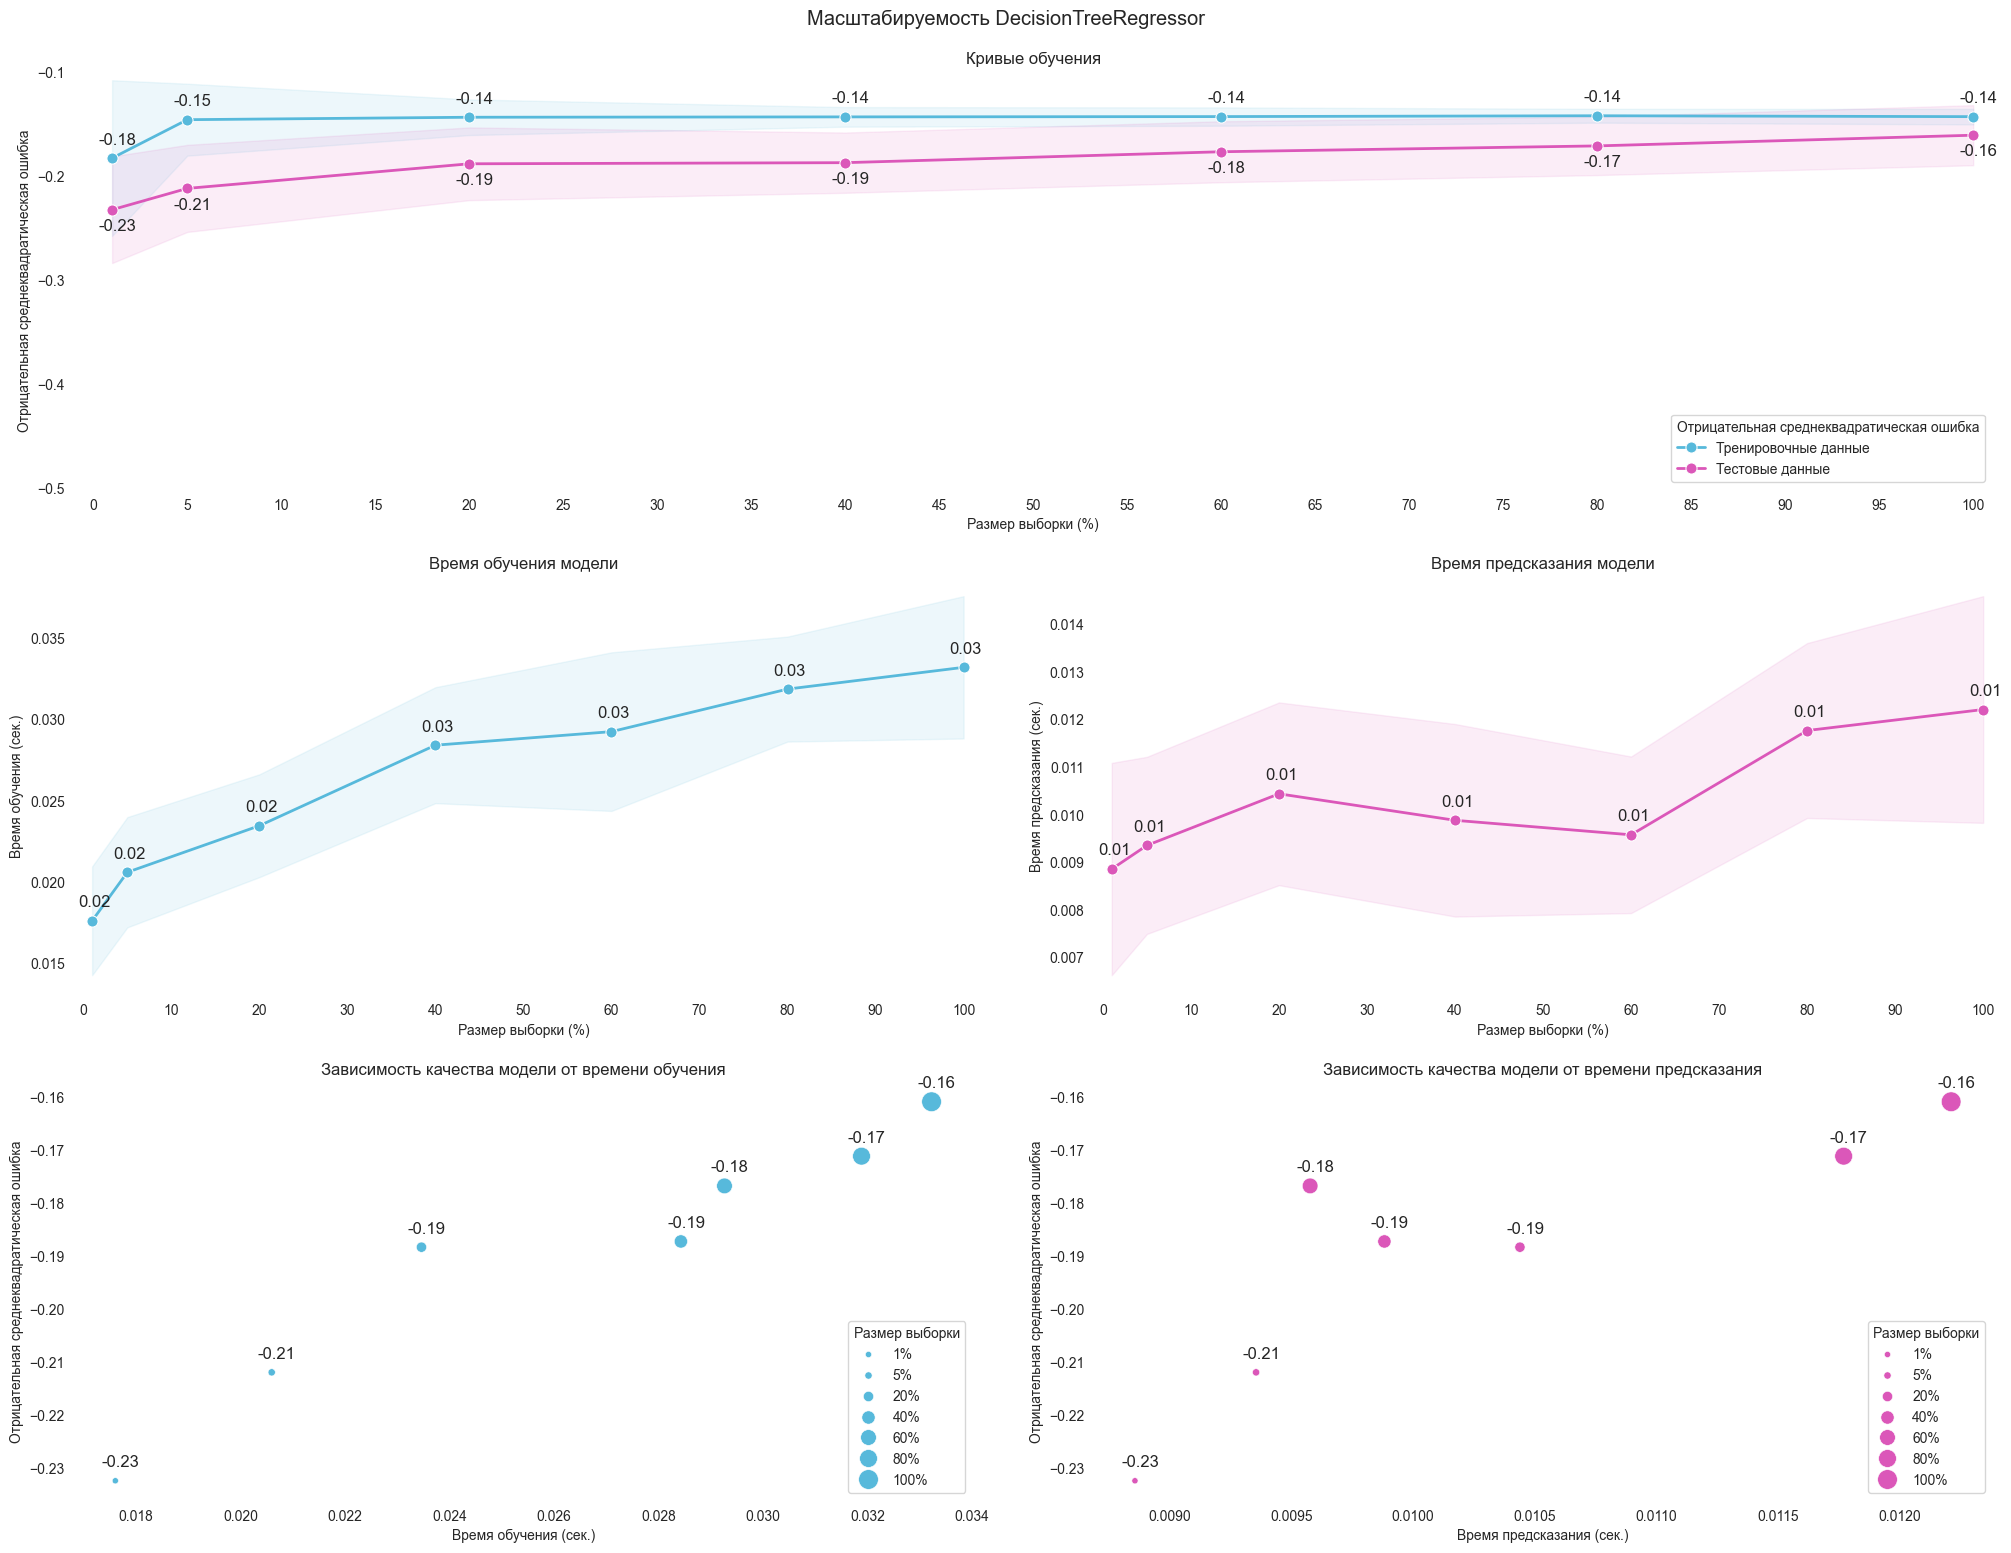

In [50]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость DecisionTreeRegressor'
)

In [51]:
predict = dt_rgs.predict(x_valid)

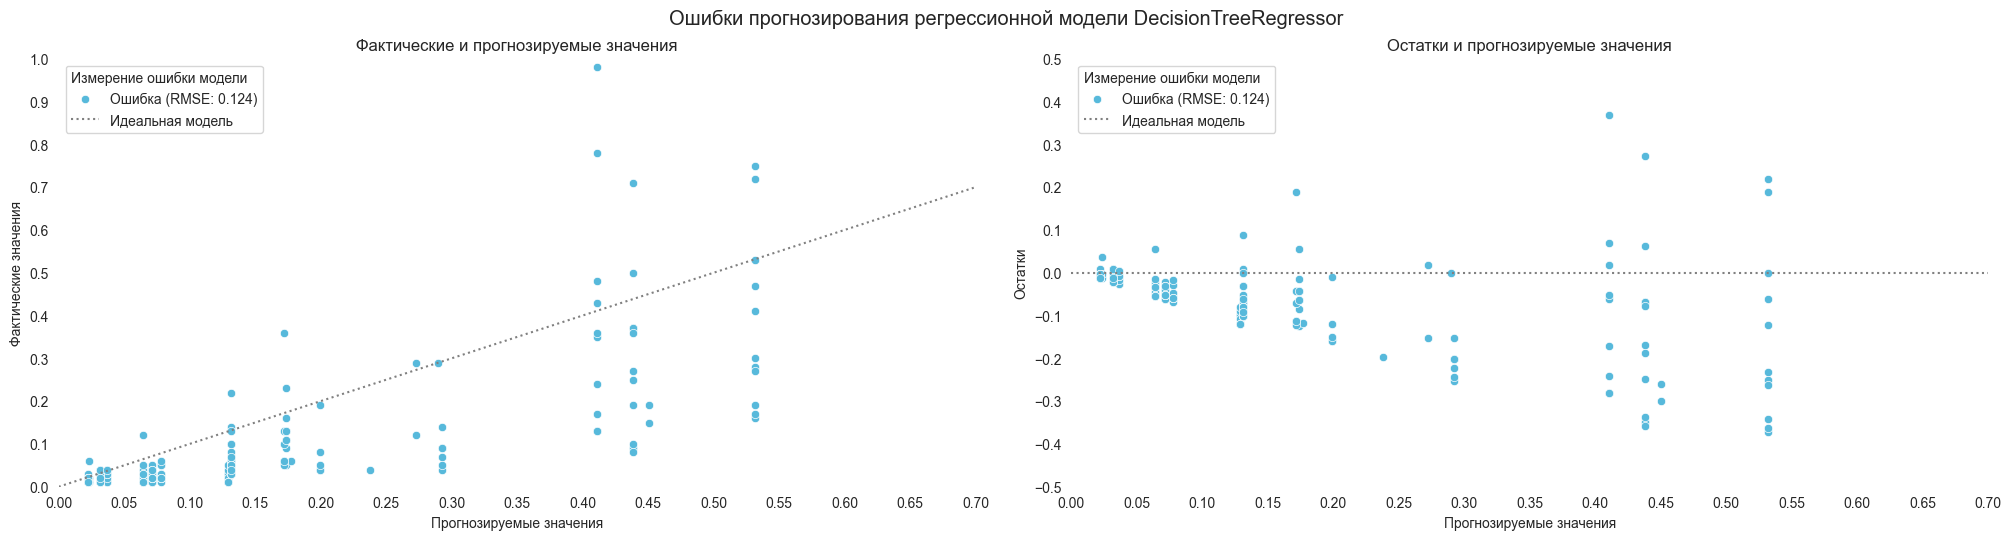

In [52]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели DecisionTreeRegressor'
)

### Тестирование RandomForestRegressor

In [53]:
estimator = RandomForestRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', RandomForestRegressor(random_state=42))])

In [54]:
param_grid = {
    'estimator__n_estimators': np.arange(150, 451, 150),
    'estimator__max_depth': np.arange(4, 13, 4),
    'estimator__min_samples_split': np.arange(2, 11, 4),
    'estimator__min_samples_leaf': np.arange(1, 10, 4)
}

In [55]:
best_param = {
    'estimator__n_estimators': [150],
    'estimator__max_depth': [8],
    'estimator__min_samples_split': [2],
    'estimator__min_samples_leaf': [5]
}

In [56]:
rf_rgs = GridSearchCV(
    estimator=model,
    cv=cv,
    scoring=scoring,
    param_grid=best_param,
    verbose=CV_VERBOSE
)

rf_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV 1/15] END estimator__max_depth=8, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.196 total time=   0.7s
[CV 2/15] END estimator__max_depth=8, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.183 total time=   0.7s
[CV 3/15] END estimator__max_depth=8, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.150 total time=   0.8s
[CV 4/15] END estimator__max_depth=8, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.189 total time=   0.8s
[CV 5/15] END estimator__max_depth=8, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=150;, score=-0.145 total time=   0.7s
[CV 6/15] END estimator__max_depth=8, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators

In [57]:
cv_results = pd.DataFrame(
    data=rf_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,params,split0_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.846617,0.0411,0.020283,0.003712,8,5,2,150,"{'estimator__max_depth': 8, 'estimator__min_sa...",-0.196315,...,-0.134448,-0.144301,-0.145741,-0.131378,-0.134604,-0.135132,-0.104227,-0.152928,0.026568,1


In [58]:
results.loc['RandomForestRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['RandomForestRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['RandomForestRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [59]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=rf_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:    5.9s remaining:   12.5s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:   12.8s remaining:    6.4s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:   19.1s finished


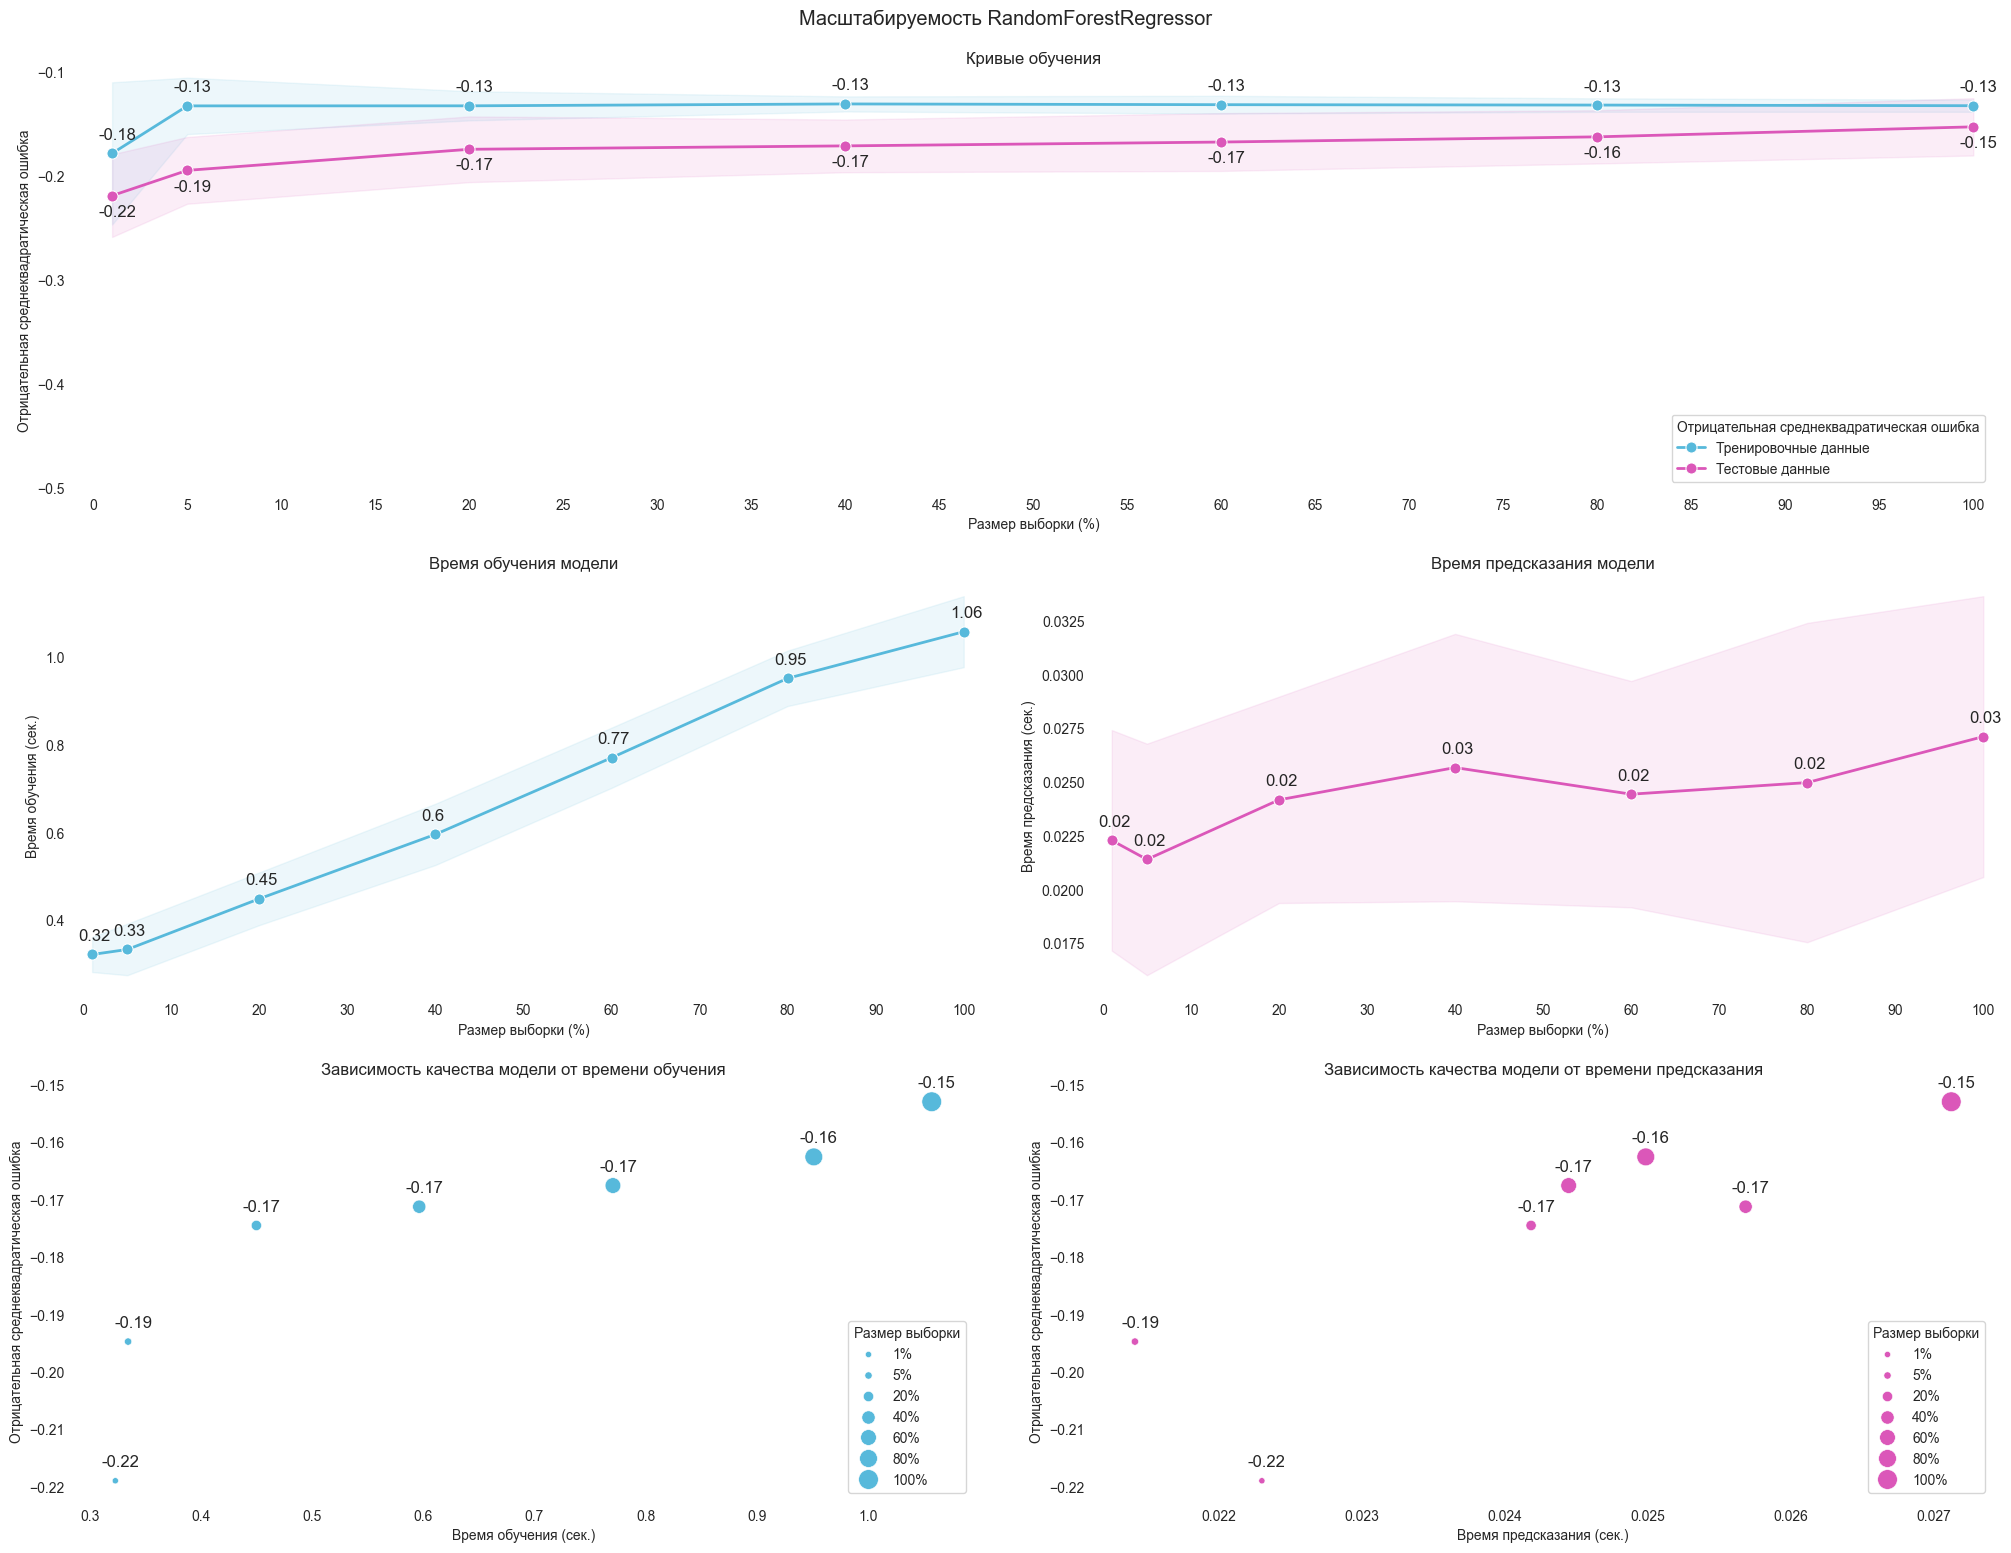

In [60]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость RandomForestRegressor'
)

In [61]:
predict = rf_rgs.predict(x_valid)

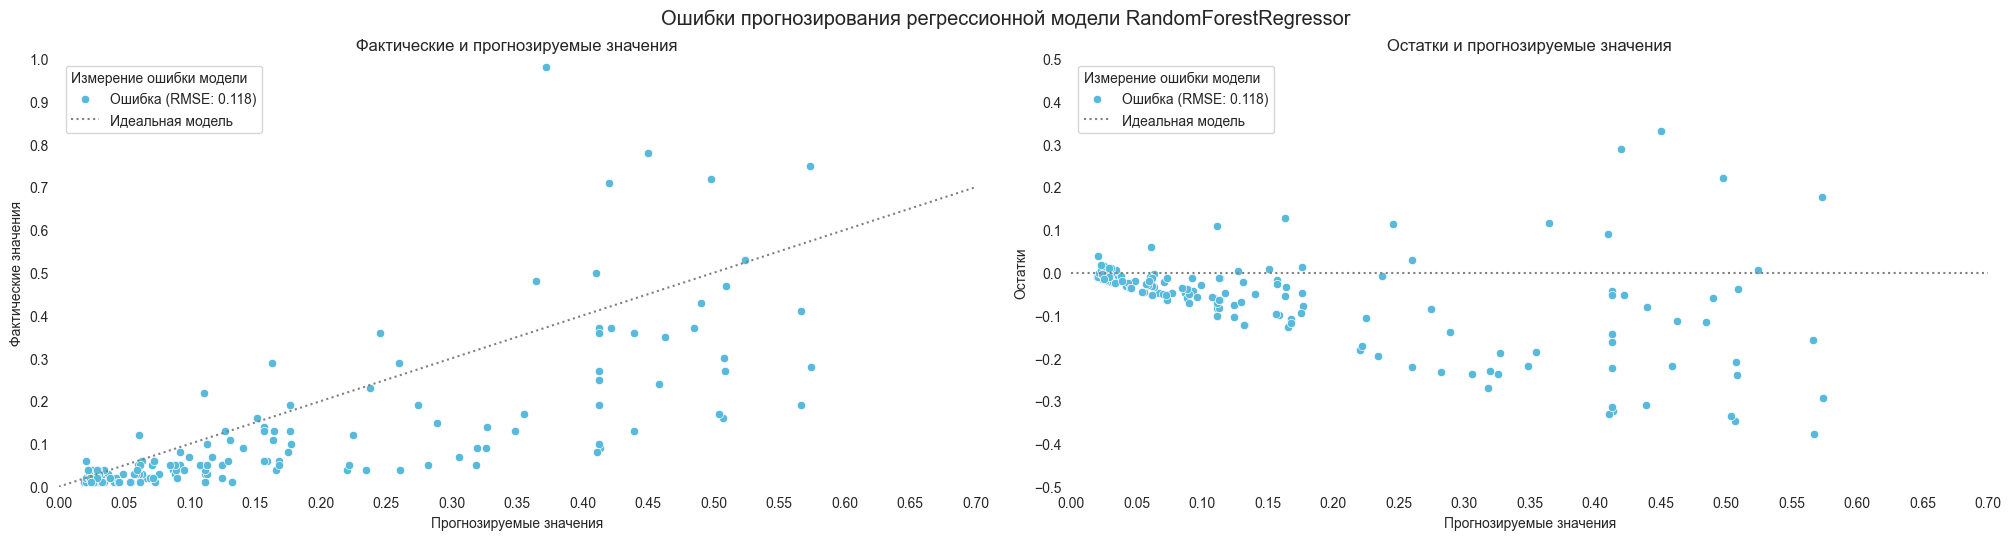

In [62]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели RandomForestRegressor'
)

### Тестирование HistGradientBoostingRegressor

In [63]:
estimator = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', HistGradientBoostingRegressor(random_state=42))])

In [64]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': np.arange(2, 9, 2),
    'estimator__max_iter': np.arange(250, 1001, 250),
    'estimator__max_leaf_nodes': np.arange(20, 41, 20),
    'estimator__min_samples_leaf': np.arange(20, 41, 20),
    'estimator__l2_regularization': np.linspace(0.0, 0.75, 4),
}

In [65]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [2],
    'estimator__max_iter': [250],
    'estimator__max_leaf_nodes': [20],
    'estimator__min_samples_leaf': [40],
    'estimator__l2_regularization': [0.25],
}

In [66]:
hgb_rgs = GridSearchCV(
    estimator=model,
    cv=cv,
    scoring=scoring,
    param_grid=best_param,
    verbose=CV_VERBOSE
)

hgb_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV 1/15] END estimator__l2_regularization=0.25, estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_iter=250, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=40;, score=-0.199 total time=   0.3s
[CV 2/15] END estimator__l2_regularization=0.25, estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_iter=250, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=40;, score=-0.186 total time=   0.1s
[CV 3/15] END estimator__l2_regularization=0.25, estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_iter=250, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=40;, score=-0.148 total time=   0.1s
[CV 4/15] END estimator__l2_regularization=0.25, estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_iter=250, estimator__max_leaf_nodes=20, estimator__min_samples_leaf=40;, score=-0.191 total time=   0.2s
[CV 5/15] END estimator__l2_regularization=0.25

In [67]:
cv_results = pd.DataFrame(
    data=hgb_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__l2_regularization,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__max_iter,param_estimator__max_leaf_nodes,param_estimator__min_samples_leaf,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.230879,0.050999,0.018014,0.004419,0.25,0.1,2,250,20,40,...,-0.13408,-0.146573,-0.140309,-0.138598,-0.132994,-0.140252,-0.10506,-0.153302,0.025733,1


In [68]:
results.loc['HistGradientBoostingRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['HistGradientBoostingRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['HistGradientBoostingRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [69]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=hgb_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:    3.0s remaining:    6.4s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:    6.2s remaining:    3.1s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:    9.4s finished


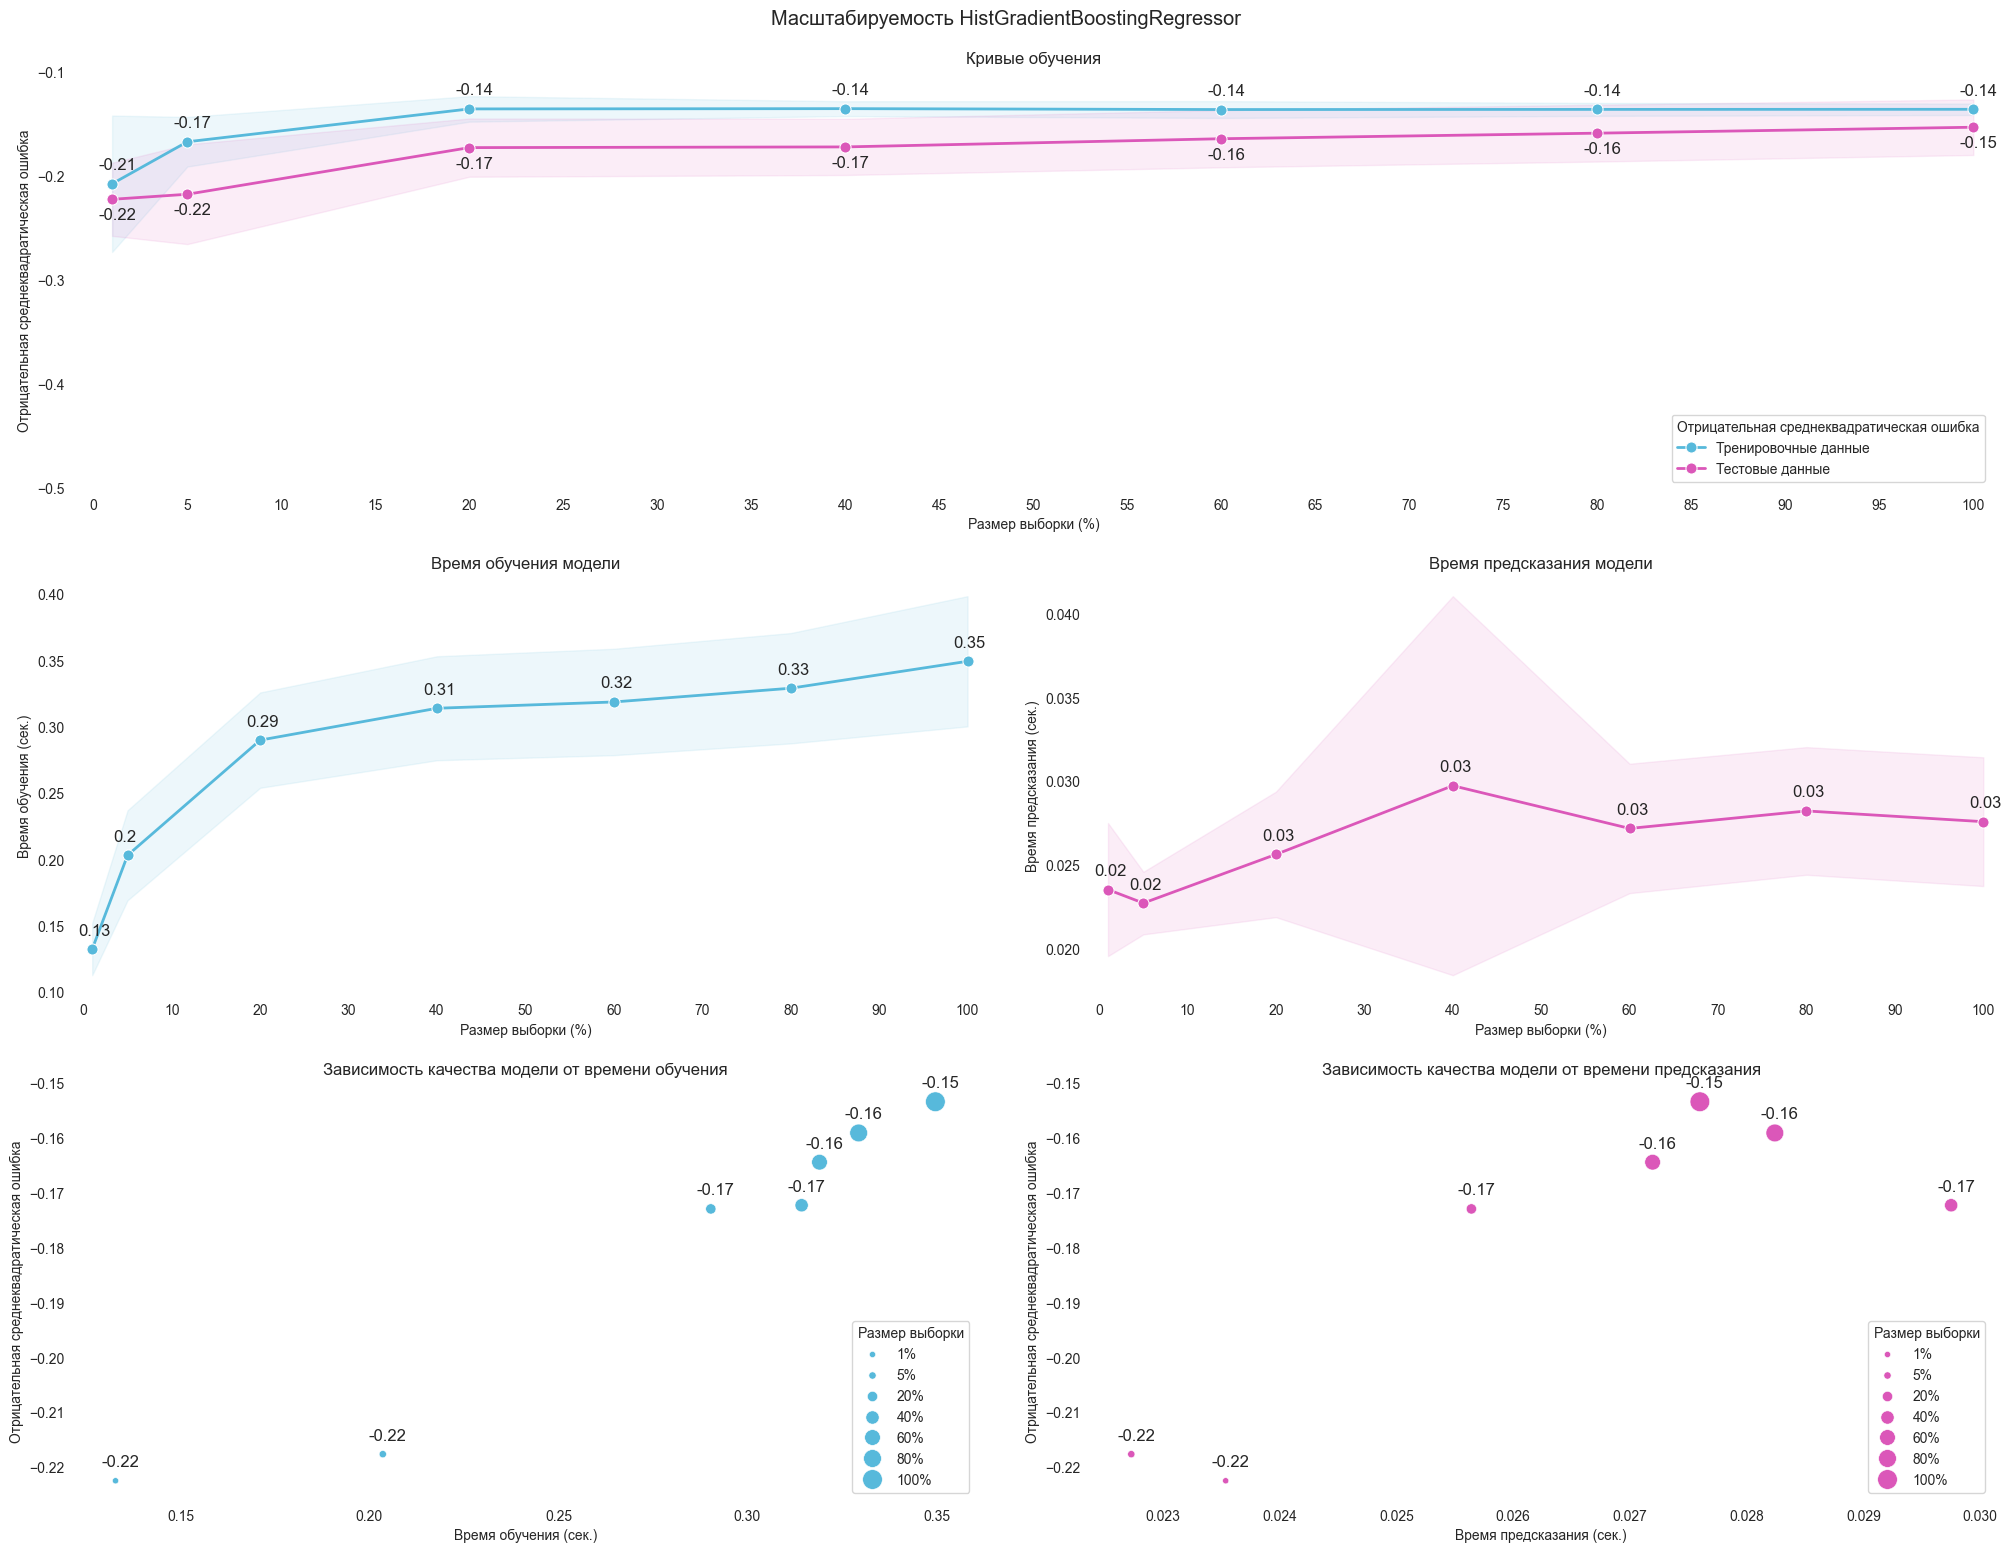

In [70]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость HistGradientBoostingRegressor'
)

In [71]:
predict = hgb_rgs.predict(x_valid)

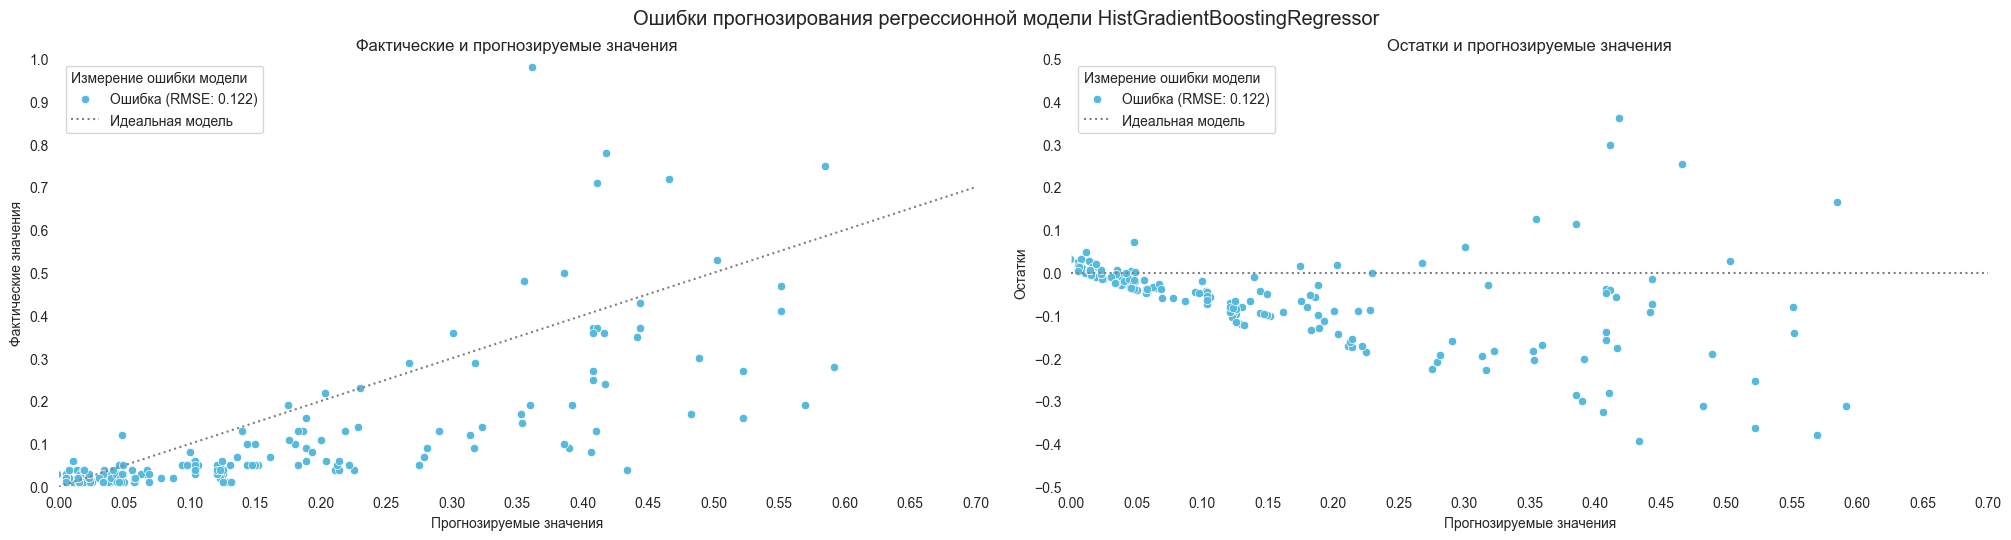

In [72]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели HistGradientBoostingRegressor'
)

### Тестирование LGBMRegressor

In [73]:
estimator = LGBMRegressor(
    random_state=RANDOM_STATE,
    verbosity=-1
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', LGBMRegressor(random_state=42, verbosity=-1))])

In [74]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': np.arange(2, 9, 2),
    'estimator__n_estimators': np.arange(250, 1001, 250),
    'estimator__num_leaves': np.arange(20, 41, 20),
    'estimator__reg_alpha': np.linspace(0.0, 0.75, 4),
    'estimator__reg_lambda': np.linspace(0.0, 0.75, 4),
}

In [75]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [2],
    'estimator__n_estimators': [250],
    'estimator__num_leaves': [20],
    'estimator__reg_alpha': [0.2],
    'estimator__reg_lambda': [0.2],
}

In [76]:
lgbm_rgs = GridSearchCV(
    estimator=model,
    cv=cv,
    scoring=scoring,
    param_grid=best_param,
    verbose=CV_VERBOSE
)

lgbm_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV 1/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=20, estimator__reg_alpha=0.2, estimator__reg_lambda=0.2;, score=-0.197 total time=   0.0s
[CV 2/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=20, estimator__reg_alpha=0.2, estimator__reg_lambda=0.2;, score=-0.187 total time=   0.0s
[CV 3/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=20, estimator__reg_alpha=0.2, estimator__reg_lambda=0.2;, score=-0.150 total time=   0.0s
[CV 4/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=20, estimator__reg_alpha=0.2, estimator__reg_lambda=0.2;, score=-0.192 total time=   0.0s
[CV 5/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estima

In [77]:
cv_results = pd.DataFrame(
    data=lgbm_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__n_estimators,param_estimator__num_leaves,param_estimator__reg_alpha,param_estimator__reg_lambda,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.078217,0.012526,0.012822,0.003303,0.1,2,250,20,0.2,0.2,...,-0.131024,-0.148152,-0.146455,-0.140339,-0.132717,-0.138521,-0.106012,-0.154161,0.025624,1


In [78]:
results.loc['LGBMRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['LGBMRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['LGBMRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [79]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=lgbm_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:    2.1s remaining:    4.5s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:    3.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:    5.4s finished


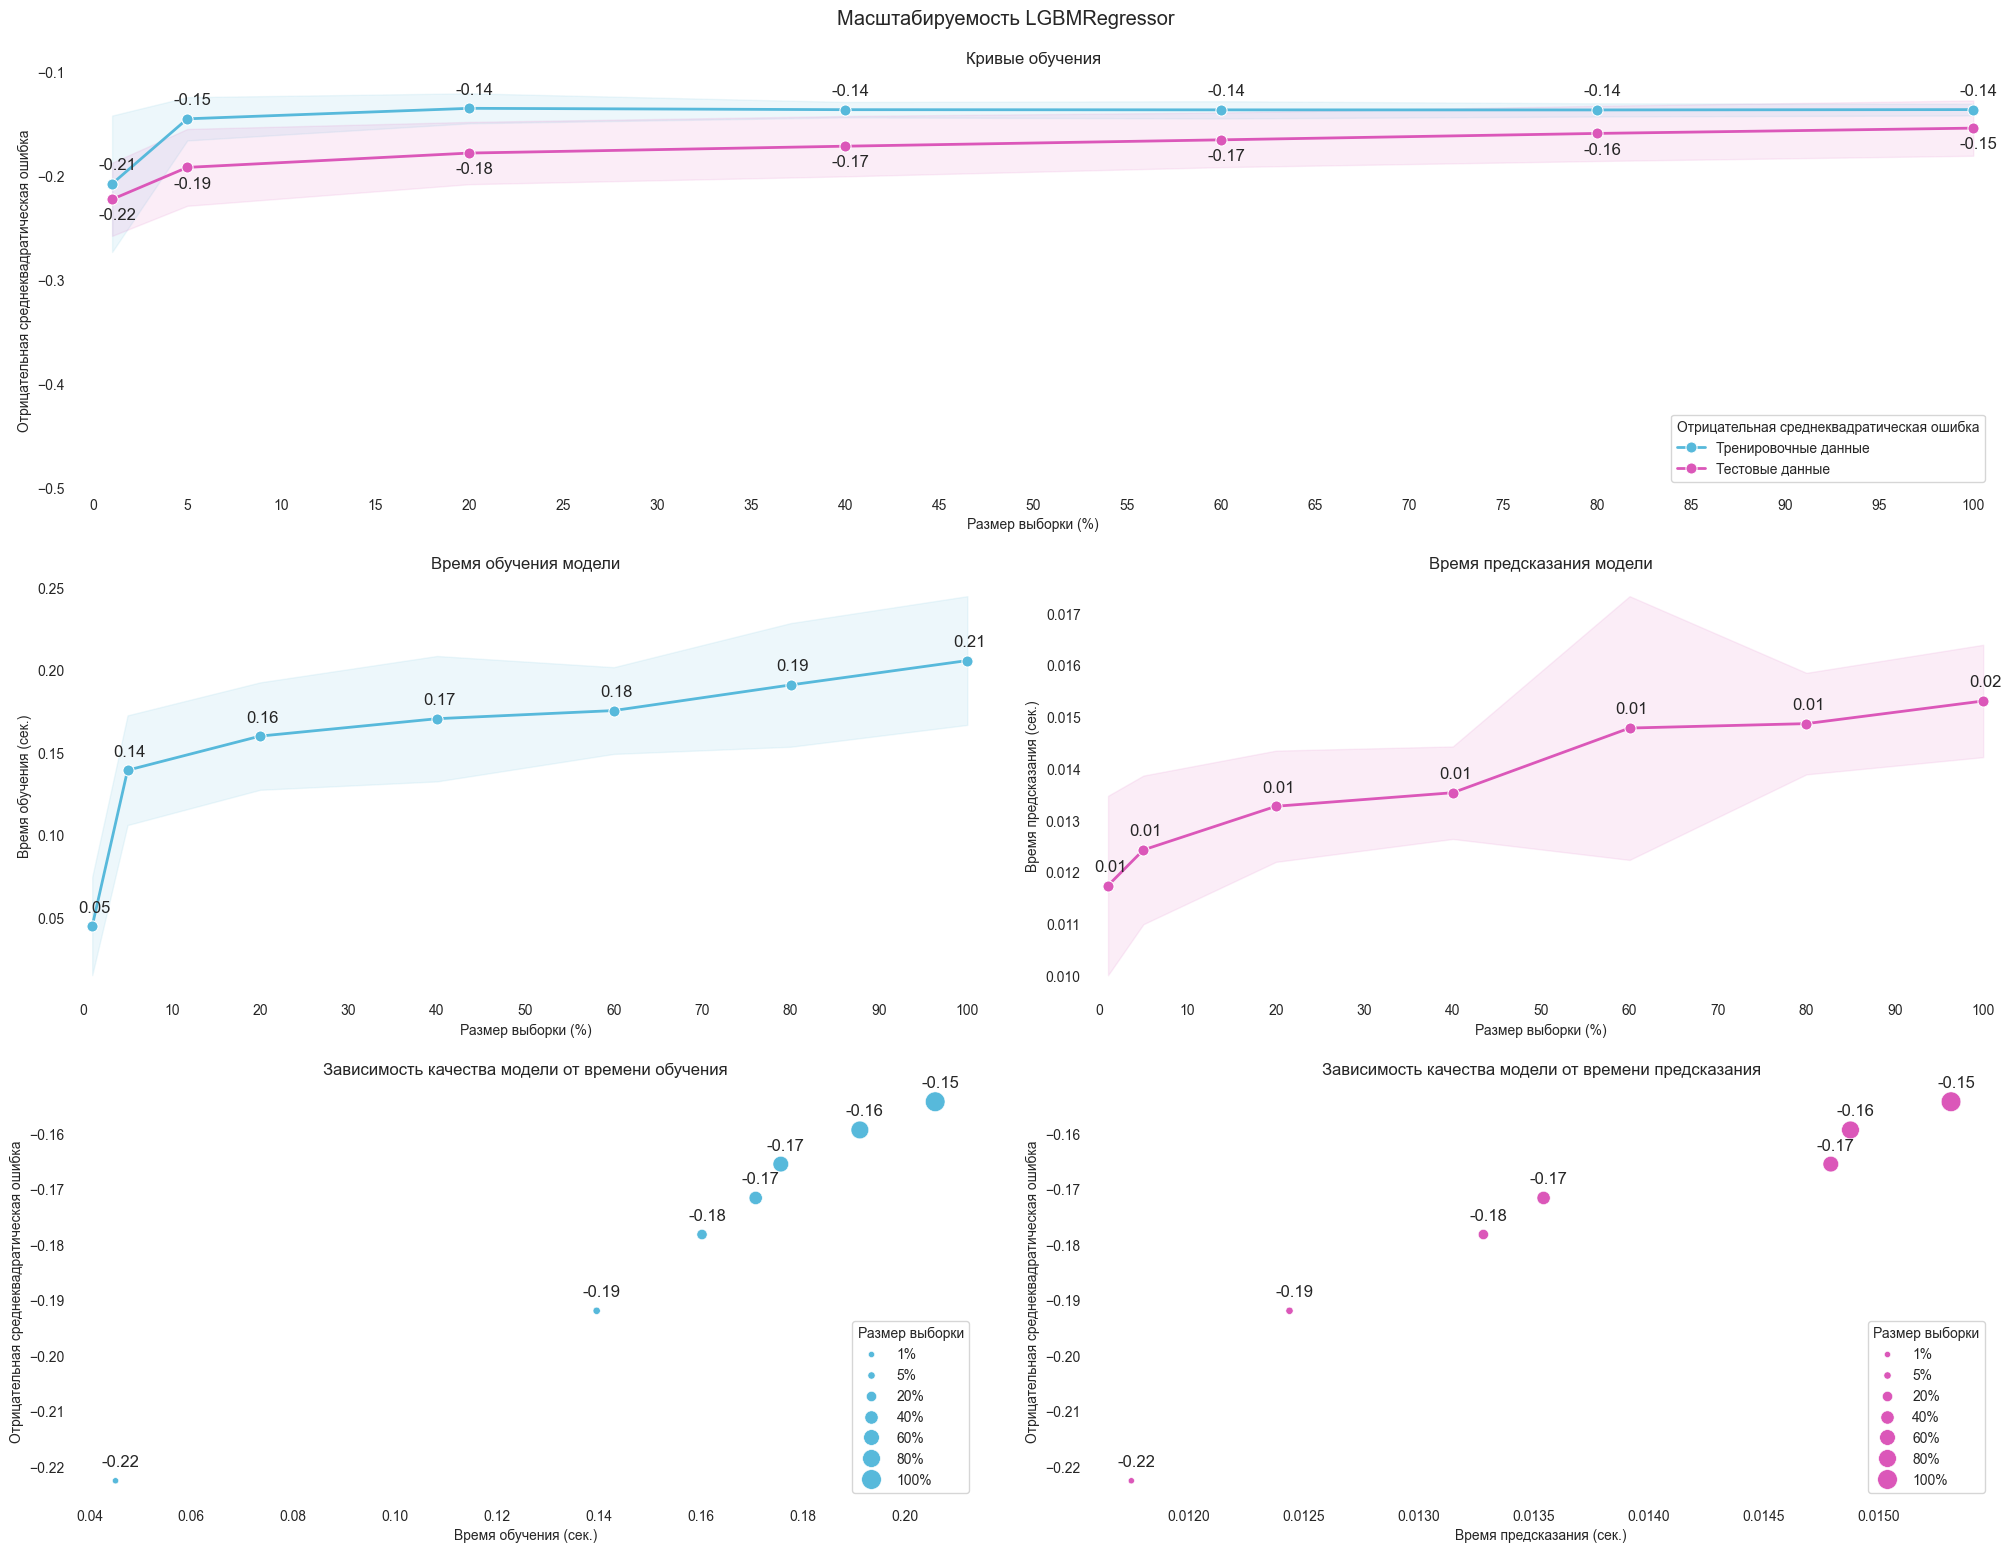

In [80]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость LGBMRegressor'
)

In [81]:
predict = lgbm_rgs.predict(x_valid)

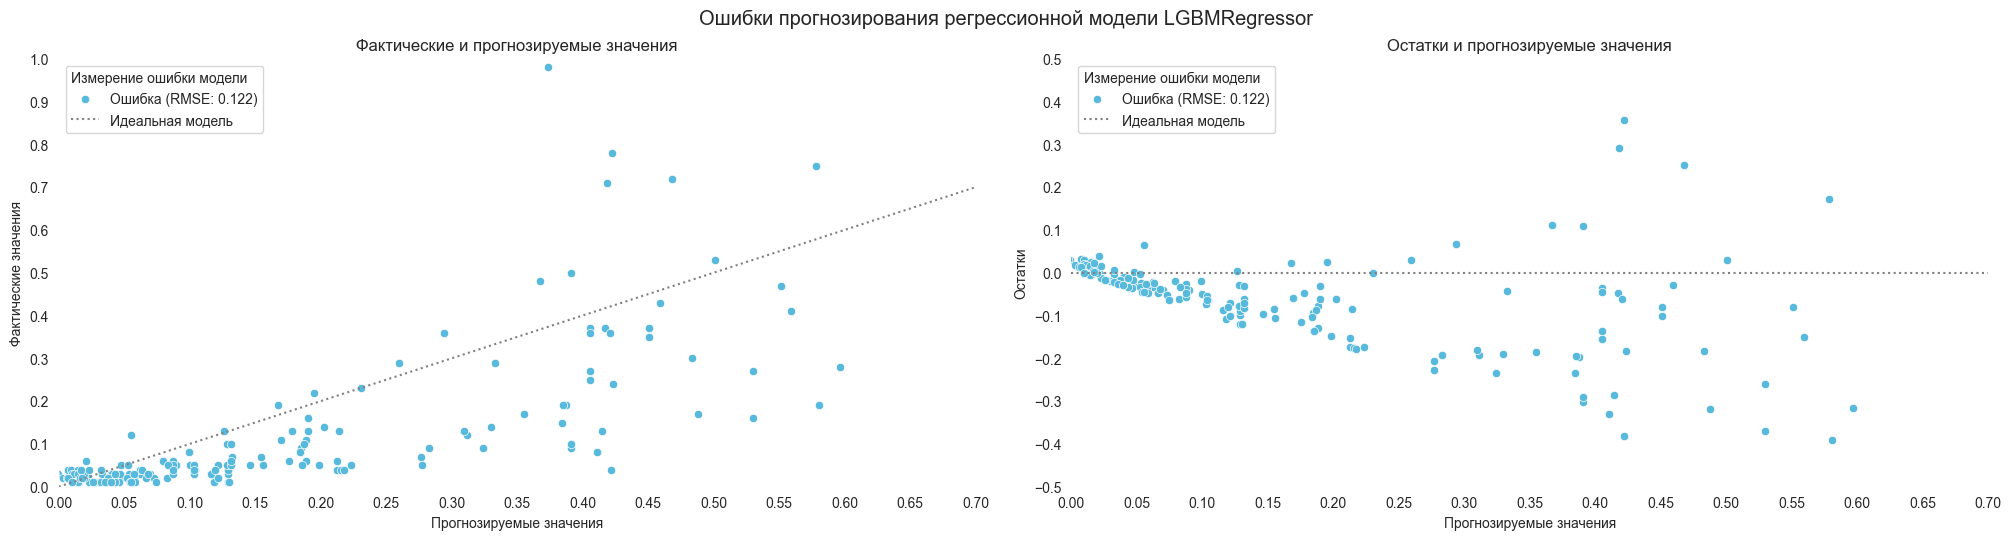

In [82]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели LGBMRegressor'
)

### Тестирование XGBRegressor

In [83]:
estimator = XGBRegressor(
    random_state=RANDOM_STATE,
    verbosity=0
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [84]:
param_grid = {
    'estimator__learning_rate': [0.1, 0.5, 1],
    'estimator__max_depth': np.arange(2, 9, 2),
    'estimator__n_estimators': np.arange(250, 1001, 250),
    'estimator__max_leaves': np.arange(20, 41, 20),
    'estimator__reg_alpha': np.linspace(0.0, 0.75, 4),
    'estimator__reg_lambda': np.linspace(0.0, 0.75, 4),
}

In [85]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [2],
    'estimator__n_estimators': [250],
    'estimator__max_leaves': [20],
    'estimator__reg_alpha': [0.75],
    'estimator__reg_lambda': [0.25],
}

In [86]:
xgb_rgs = GridSearchCV(
    estimator=model,
    cv=cv,
    scoring=scoring,
    param_grid=best_param,
    verbose=CV_VERBOSE
)

xgb_rgs.fit(x_train, y_train);

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV 1/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=20, estimator__n_estimators=250, estimator__reg_alpha=0.75, estimator__reg_lambda=0.25;, score=-0.194 total time=   0.4s
[CV 2/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=20, estimator__n_estimators=250, estimator__reg_alpha=0.75, estimator__reg_lambda=0.25;, score=-0.184 total time=   0.1s
[CV 3/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=20, estimator__n_estimators=250, estimator__reg_alpha=0.75, estimator__reg_lambda=0.25;, score=-0.149 total time=   0.1s
[CV 4/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=20, estimator__n_estimators=250, estimator__reg_alpha=0.75, estimator__reg_lambda=0.25;, score=-0.191 total time=   0.1s
[CV 5/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__max_leaves=20, e

In [87]:
cv_results = pd.DataFrame(
    data=xgb_rgs.cv_results_, 
).sort_values('rank_test_score')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__max_leaves,param_estimator__n_estimators,param_estimator__reg_alpha,param_estimator__reg_lambda,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.197591,0.070678,0.018612,0.001228,0.1,2,20,250,0.75,0.25,...,-0.131106,-0.145403,-0.144837,-0.136232,-0.133898,-0.138442,-0.10897,-0.153307,0.024589,1


In [88]:
results.loc['XGBRegressor', 'Время обучения'] = cv_results.iloc[0, 0]
results.loc['XGBRegressor', 'Время предсказания'] = cv_results.iloc[0, 2]
results.loc['XGBRegressor', 'RMSE'] = cv_results.iloc[0, -3]

In [89]:
(train_sizes,
 train_scores, test_scores,
 fit_times, score_times) = learning_curve(
    estimator=xgb_rgs.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=LEARNING_CURVE_TRAIN_SIZES,
    cv=cv,
    n_jobs=N_JOBS,
    scoring='neg_root_mean_squared_error',
    return_times=True,
    verbose=CV_VERBOSE
)

[learning_curve] Training set sizes: [  20  100  400  800 1200 1600 2000]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  34 out of 105 | elapsed:    1.9s remaining:    4.1s
[Parallel(n_jobs=4)]: Done  70 out of 105 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=4)]: Done 105 out of 105 | elapsed:    5.3s finished


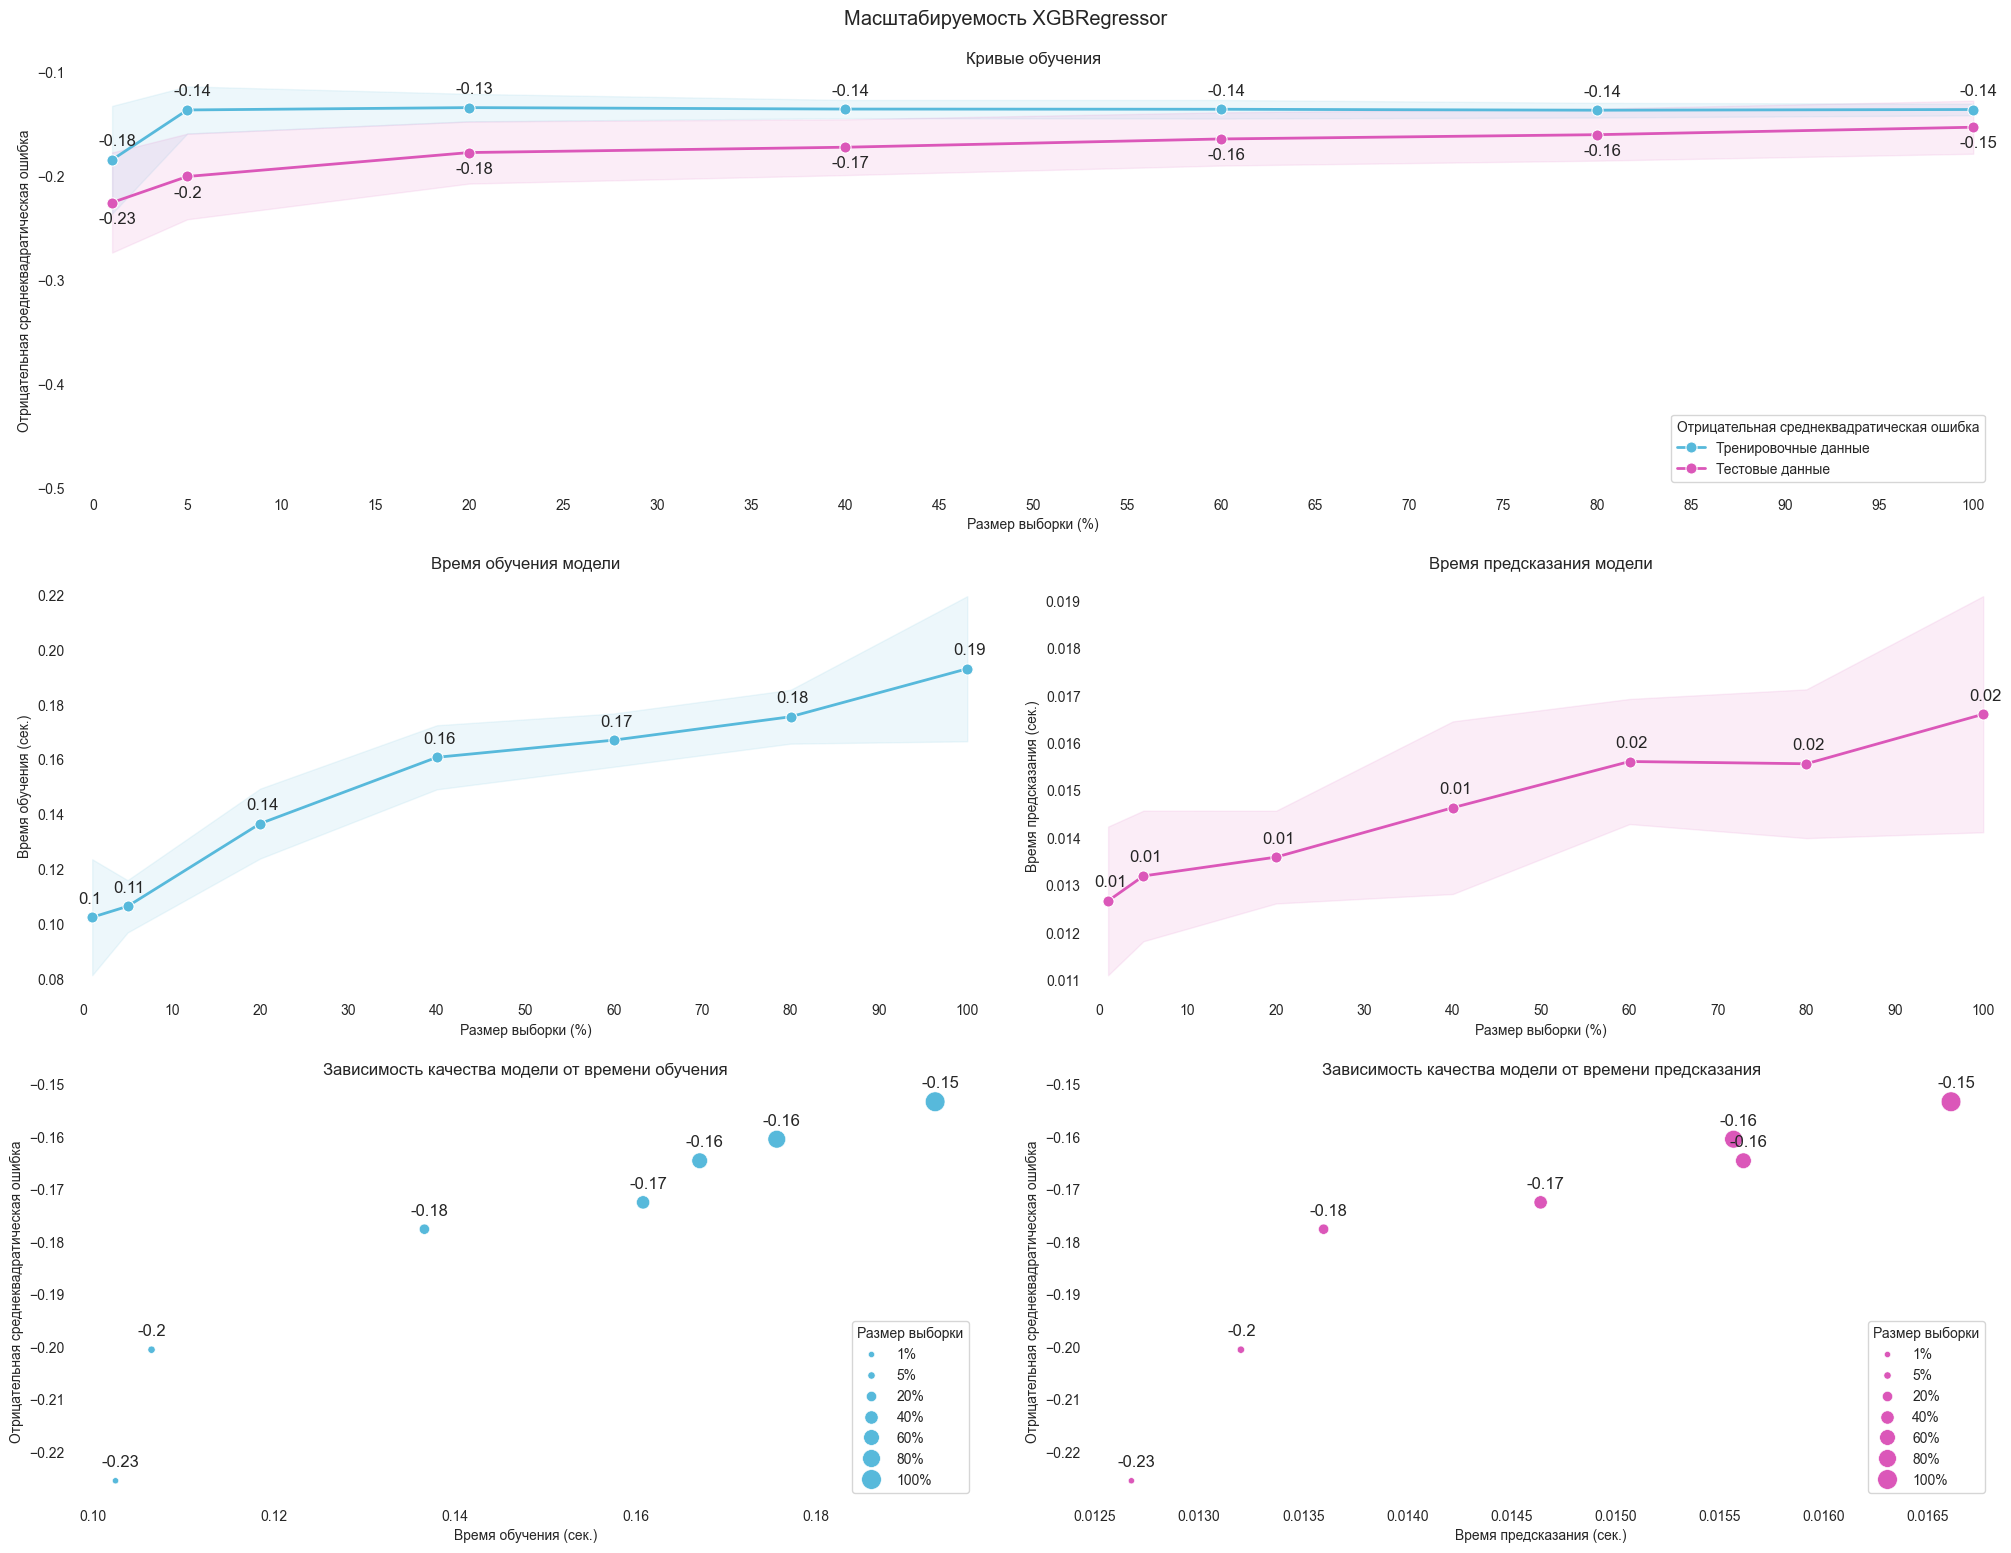

In [90]:
x_train_size = CV_TRAIN_SIZE
plot.scalability(
    train_sizes=pd.Series((train_sizes / x_train_size * 100).round(1)),
    train_scores=pd.DataFrame(train_scores),
    test_scores=pd.DataFrame(test_scores),
    fit_times=pd.DataFrame(fit_times),
    score_times=pd.DataFrame(score_times),
    title=f'Масштабируемость XGBRegressor'
)

In [91]:
predict = xgb_rgs.predict(x_valid)

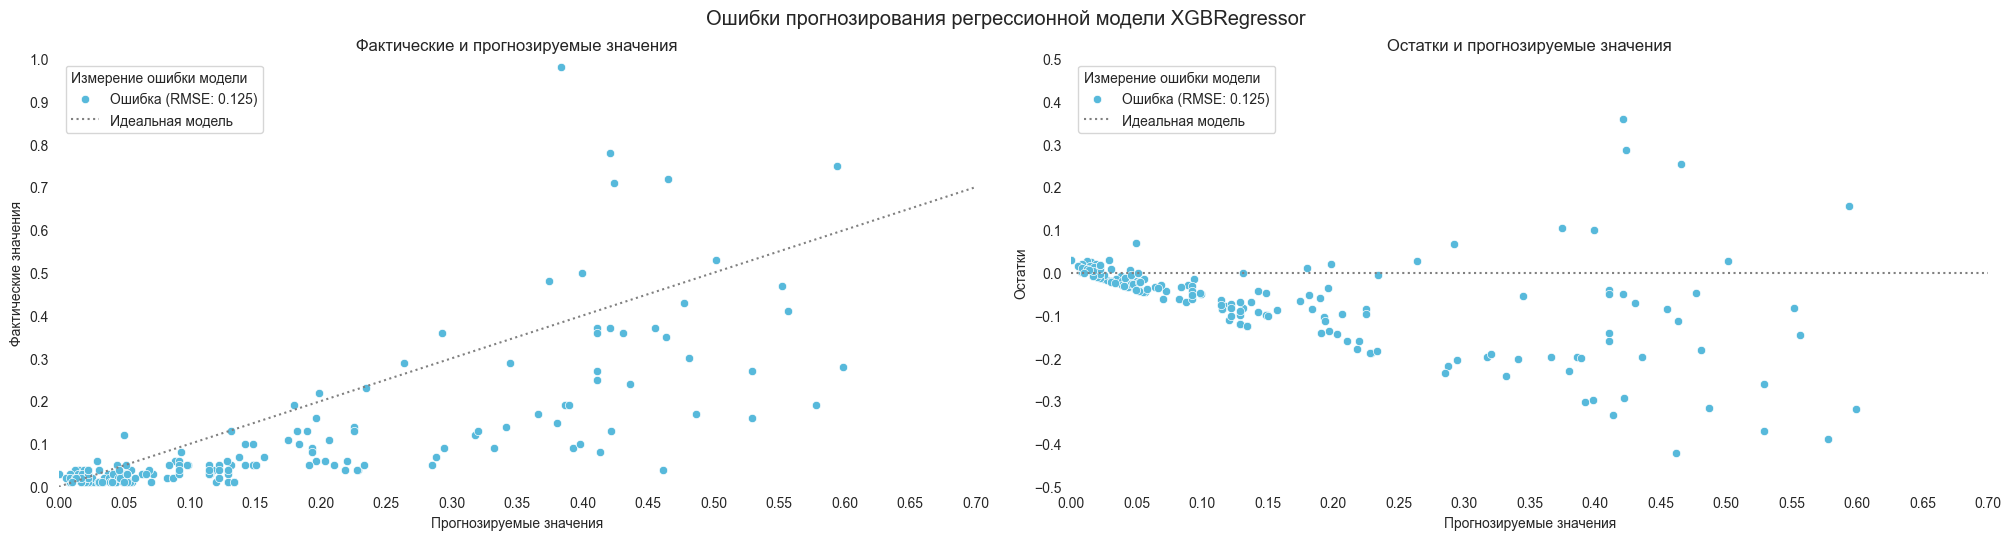

In [92]:
plot.error(
    y_true=pd.Series(y_valid), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели XGBRegressor'
)

### Выводы по тестированию моделей
***

In [93]:
results.style.format(na_rep='-')

,Время обучения,Время предсказания,RMSE
DecisionTreeRegressor,0.025654,0.008896,-0.160952
RandomForestRegressor,0.846617,0.020283,-0.152928
HistGradientBoostingRegressor,0.230879,0.018014,-0.153302
LGBMRegressor,0.078217,0.012822,-0.154161
XGBRegressor,0.197591,0.018612,-0.153307


1. Для кодирования признаков использован **TargetEncoder**.
2. Дляля оценки эффективности **предсказательной способности** модели использована метрика **RMSE**.
3. Для **оценки эффективности** были выбраны следующие показатели:
    - время обучения;
    - время предсказания;
    - RMSE.
4. DecisionTreeRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.02** сек.;
        - среднее время предсказания: до **0.01** сек.;
        - среднее значение RMSE: **0.160**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.124**;
        - **присутствует гетероскедастичность** остатков.
5. RandomForestRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.85** сек.;
        - среднее время предсказания: до **0.025** сек.;
        - среднее значение RMSE: **0.152**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.118**;
        - **присутствует гетероскедастичность** остатков.
6. HistGradientBoostingRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.25** сек.;
        - среднее время предсказания: до **0.02** сек.;
        - среднее значение RMSE: **0.153**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.122**;
        - **присутствует гетероскедастичность** остатков.
6. LGBMRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.1** сек.;
        - среднее время предсказания: до **0.02** сек.;
        - среднее значение RMSE: **0.154**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.122**;
        - **присутствует гетероскедастичность** остатков.
7. XGBRegressor:
    - результаты кросс-валидации:
        - среднее время обучения: до **0.2** сек.;
        - среднее время предсказания: до **0.02** сек.;
        - среднее значение RMSE: **0.153**.
    - оценка масштабируемости:
        - кривые обучения показывают, что признак переобучения модели **отсутствует**;
        - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
        - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
    - оценка ошибки прогнозирования на валидационной выборке:
        - значение RMSE - **0.125**;
        - **присутствует гетероскедастичность** остатков.

## Проверка модели на тестовой выборке

In [94]:
x = pd.concat([x_train, x_valid])
x

,platform,publisher,developer,america,europe,japan,other
0,PC,505 Games,BiArt Studios,False,False,False,False
1,PC,Paradox Interactive,Most Wanted Entertainment,False,True,False,False
2,2600,Atari,Atari,True,True,False,True
3,2600,Atari,Atari,True,True,False,False
4,2600,Atari,Atari,True,True,False,False
...,...,...,...,...,...,...,...
15322,NS,GameMill Entertainment,"Concrete Software, Inc.",True,False,False,False
15323,NS,Rising Star,Zoink Games,True,False,False,False
15324,XOne,Koei Tecmo,Omega Force,True,False,False,False
15325,PS4,2K Games,Saber Interactive,True,False,False,True


In [95]:
y = pd.concat([y_train, y_valid])
y

0        0.01
1        0.01
2        0.98
3        0.27
4        0.44
         ... 
15322    0.02
15323    0.01
15324    0.04
15325    0.08
15326    0.22
Name: total, Length: 15327, dtype: float32

In [96]:
category = [
    'platform',
    'publisher', 
    'developer', 
    'america', 
    'europe', 
    'japan', 
    'other'
]
encoder = TargetEncoder(
    random_state=RANDOM_STATE
)

standardizer = ColumnTransformer(
     transformers=[
            ('encoder', encoder, category)
        ],
    remainder='passthrough'
)

standardizer

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder', TargetEncoder(random_state=42),
                                 ['platform', 'publisher', 'developer',
                                  'america', 'europe', 'japan', 'other'])])

In [97]:
estimator = LGBMRegressor(
    random_state=RANDOM_STATE,
    verbosity=-1
)
model = Pipeline(
    steps=[
        ('standardizer', standardizer),
        ('estimator', estimator),
    ]
)
model

Pipeline(steps=[('standardizer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  TargetEncoder(random_state=42),
                                                  ['platform', 'publisher',
                                                   'developer', 'america',
                                                   'europe', 'japan',
                                                   'other'])])),
                ('estimator', LGBMRegressor(random_state=42, verbosity=-1))])

In [98]:
best_param = {
    'estimator__learning_rate': [0.1],
    'estimator__max_depth': [2],
    'estimator__n_estimators': [250],
    'estimator__num_leaves': [20],
    'estimator__reg_alpha': [0.2],
    'estimator__reg_lambda': [0.2],
}

In [99]:
rf_rgs = GridSearchCV(
    estimator=model,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    param_grid=best_param,
    verbose=CV_VERBOSE
)

rf_rgs.fit(x, y);

Fitting 15 folds for each of 1 candidates, totalling 15 fits
[CV 1/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=20, estimator__reg_alpha=0.2, estimator__reg_lambda=0.2;, score=-0.187 total time=   0.0s
[CV 2/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=20, estimator__reg_alpha=0.2, estimator__reg_lambda=0.2;, score=-0.150 total time=   0.0s
[CV 3/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=20, estimator__reg_alpha=0.2, estimator__reg_lambda=0.2;, score=-0.192 total time=   0.0s
[CV 4/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estimator__num_leaves=20, estimator__reg_alpha=0.2, estimator__reg_lambda=0.2;, score=-0.144 total time=   0.0s
[CV 5/15] END estimator__learning_rate=0.1, estimator__max_depth=2, estimator__n_estimators=250, estima

In [100]:
predict = rf_rgs.predict(x_test)

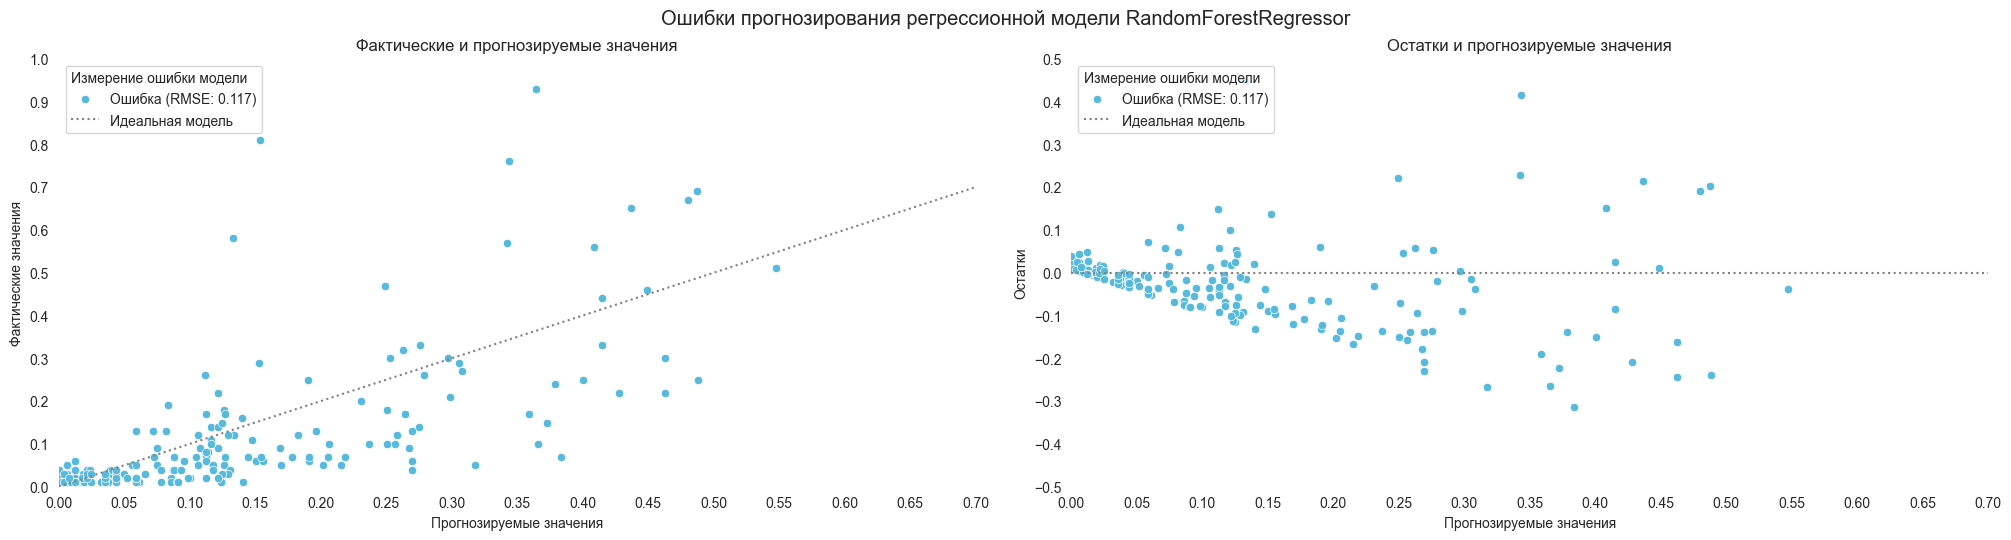

In [101]:
plot.error(
    y_true=pd.Series(y_test), 
    y_predict=pd.Series(predict),
    title='Ошибки прогнозирования регрессионной модели RandomForestRegressor'
)

## Сравнение с фиктивным регрессором

In [102]:
dummy_rgs = DummyRegressor(strategy="mean")
dummy_rgs

DummyRegressor()

In [103]:
dummy_rgs.fit(x_train[-1000:], y_train[-1000:])

DummyRegressor()

In [104]:
predict = dummy_rgs.predict(x_test)

In [105]:
root_mean_squared_error(y_test, predict)

0.16316892

# Выводы

1. Отбор данных:
    - в качестве целевого признака был выбран признак **total**.
    - в качестве независимых признаков были выбраны:
        - date;
        - platform;
        - publisher;
        - developer;
        - america;
        - europe;
        - japan;
        - other.
    - были выбраны записи, в которых в поле **total** значения **не превышали 1.0**.
2. Преобразование данных:
    - для поля **date** был оставлен только год выпуска видеоигры;
    - для полей **america**, **europe**, **japan**, **other** значение было заменено на **True** и **False**, чтобы предотвратить **утечки целевого признака**.
3. Данные были разделены на **тренировочную**, **валидационную** и **тестовую** выборки в отношении **0.5:0.5:9**.
4. Тестирование моделей:
    - Для кодирования признаков использован **TargetEncoder**.
    - Дляля оценки эффективности **предсказательной способности** модели использована метрика **RMSE**.
    - Для **оценки эффективности** были выбраны следующие показатели:
        - время обучения;
        - время предсказания;
        - RMSE.
    1. DecisionTreeRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.02** сек.;
            - среднее время предсказания: до **0.01** сек.;
            - среднее значение RMSE: **0.160**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.124**;
            - **присутствует гетероскедастичность** остатков.
    2. RandomForestRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.85** сек.;
            - среднее время предсказания: до **0.025** сек.;
            - среднее значение RMSE: **0.152**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.118**;
            - **присутствует гетероскедастичность** остатков.
    3. HistGradientBoostingRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.25** сек.;
            - среднее время предсказания: до **0.02** сек.;
            - среднее значение RMSE: **0.153**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.122**;
            - **присутствует гетероскедастичность** остатков.
    4. LGBMRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.1** сек.;
            - среднее время предсказания: до **0.02** сек.;
            - среднее значение RMSE: **0.154**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.122**;
            - **присутствует гетероскедастичность** остатков.
    5. XGBRegressor:
        - результаты кросс-валидации:
            - среднее время обучения: до **0.2** сек.;
            - среднее время предсказания: до **0.02** сек.;
            - среднее значение RMSE: **0.153**.
        - оценка масштабируемости:
            - кривые обучения показывают, что признак переобучения модели **отсутствует**;
            - **добавление новых данных** вероятнее всего **не улучшит** предсказательную способность модели;
            - при добавении новых данных **время обучения** и **время предсказания** возрастают **линейно**.
        - оценка ошибки прогнозирования на валидационной выборке:
            - значение RMSE - **0.125**;
            - **присутствует гетероскедастичность** остатков.
5. Проверка модели на тестовой выборке:
    - в качестве итоговой модели была выбрана модель **LGBMRegressor**;
    - значение RMSE на тестовой выборе было равно **0.117**.
6. Сравнение с фиктивным регрессором:
    - в качестве фиктивного регресора был выбран **DummyRegressor** со стратегией **mean**;
    - значение RMSE на тестовой выборе для фиктивного регрессора было равно **0.163**.